In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import cv2
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
import torchvision.transforms.functional as F

import h5py

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.use_deterministic_algorithms(True)

from model import StarChartModel, StarData

In [2]:
with h5py.File("train.1.h5", "r") as f:
    train_images1 = np.array(f["X"])
    train_labels1 = np.array(f["y"])
with h5py.File("train.2.h5", "r") as f:
    train_images2 = np.array(f["X"])
    train_labels2 = np.array(f["y"])
train_images = np.concatenate((train_images1, train_images2))
train_labels = np.concatenate((train_labels1, train_labels2))
with h5py.File("test.h5", "r") as f:
    test_images = np.array(f["X"])

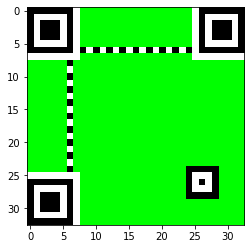

In [3]:
mask = np.array(Image.open("mask.png"))
plt.figure()
plt.imshow(mask)

array([[[0.01176471, 0.00784314, 0.        ],
        [0.01568627, 0.01176471, 0.00392157],
        [0.01176471, 0.00784314, 0.        ],
        ...,
        [0.01960784, 0.02745098, 0.01568627],
        [0.02745098, 0.03529412, 0.02352941],
        [0.01960784, 0.02745098, 0.01568627]],

       [[0.01568627, 0.01176471, 0.00784314],
        [0.02352941, 0.01568627, 0.01176471],
        [0.01176471, 0.00392157, 0.00392157],
        ...,
        [0.01176471, 0.01960784, 0.00784314],
        [0.02352941, 0.03137255, 0.01960784],
        [0.02352941, 0.03137255, 0.01960784]],

       [[0.01960784, 0.01176471, 0.01568627],
        [0.02352941, 0.01568627, 0.01960784],
        [0.01960784, 0.01176471, 0.01568627],
        ...,
        [0.00392157, 0.01176471, 0.00392157],
        [0.01568627, 0.02352941, 0.01176471],
        [0.02352941, 0.03137255, 0.01960784]],

       ...,

       [[0.01176471, 0.01176471, 0.00392157],
        [0.00784314, 0.00784314, 0.00392157],
        [0.00784314, 0

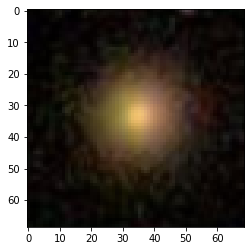

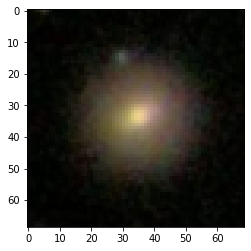

In [4]:
plt.figure()
plt.imshow(test_images[0, 0, 0]/255)
plt.figure()
plt.imshow(test_images[0, 0, 1]/255)


test_images[0, 0, 0]/255

In [5]:
test_images.shape

(33, 33, 2, 69, 69, 3)

array([[[0.04705882, 0.03137255, 0.01960784],
        [0.03529412, 0.01568627, 0.01568627],
        [0.03137255, 0.02352941, 0.01960784],
        ...,
        [0.02745098, 0.02352941, 0.02352941],
        [0.01568627, 0.01176471, 0.01176471],
        [0.01568627, 0.01176471, 0.01176471]],

       [[0.04313725, 0.02745098, 0.01568627],
        [0.04705882, 0.03137255, 0.02352941],
        [0.03529412, 0.02745098, 0.01960784],
        ...,
        [0.04705882, 0.03137255, 0.03921569],
        [0.02745098, 0.01568627, 0.02352941],
        [0.02352941, 0.01568627, 0.02352941]],

       [[0.05490196, 0.03921569, 0.02745098],
        [0.07058824, 0.05490196, 0.04313725],
        [0.05490196, 0.04705882, 0.03137255],
        ...,
        [0.10588235, 0.07058824, 0.09019608],
        [0.05098039, 0.02745098, 0.04313725],
        [0.02745098, 0.01176471, 0.02745098]],

       ...,

       [[0.01568627, 0.01568627, 0.00784314],
        [0.01176471, 0.00784314, 0.        ],
        [0.01568627, 0

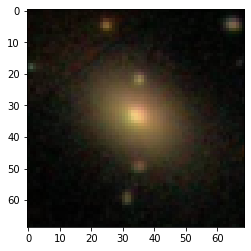

In [6]:
plt.figure()
plt.imshow(train_images[42]/255)

train_images[42]/255

In [7]:
train_images.shape, train_labels.shape

((10632, 69, 69, 3), (10632,))

In [8]:
def read_qr_code(image):
    """Read an image and read the QR code.
    
    Args:
        image (np Array): np img
    
    Returns:
        qr (string): Value from QR code
    """
    detect = cv2.QRCodeDetector()
    value, points, straight_qrcode = detect.detectAndDecode(image)
    return value


In [9]:
read_qr_code(cv2.imread("qr.bmp"))

'http://en.m.wikipedia.org'

In [10]:
flag = np.zeros((33,33))

In [11]:
model = StarChartModel([0.3,0.15])

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0005)

In [13]:
preprocess = transforms.Compose([
    transforms.Normalize(
        mean=np.array([0.1086, 0.0934, 0.0711]),
        std=np.array([0.1472, 0.123, 0.1032]))
])

In [14]:
def build_response(test_images, model):
	final = np.zeros((33, 33, 2), dtype=np.uint8)

	for y, _ in enumerate(test_images):
		for x, _ in enumerate(test_images[y]):
			for i in range(2):
				data = preprocess(torch.tensor(test_images[y][x][i].transpose(2,0,1)/255).float())
				#print(data.shape)
				pred = model.forward(torch.unsqueeze(data, 0))
				final[y][x][i] = torch.argmin(pred[0], axis=0)
	return final

In [15]:
batch_size = 32
train_set = StarData((train_images.transpose(0,3,1,2)/255), train_labels, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)


epoch 1 loss: 6.745


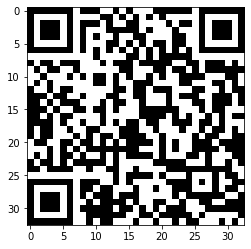

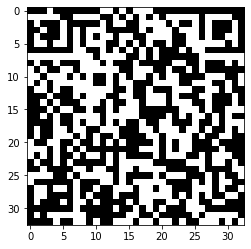

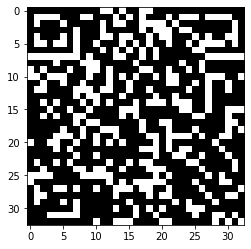

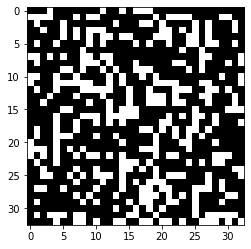

epoch 2 loss: 5.080


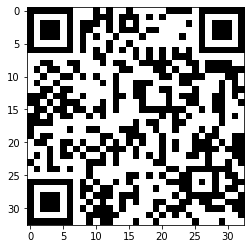

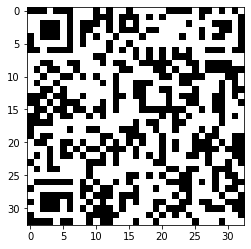

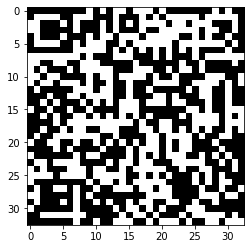

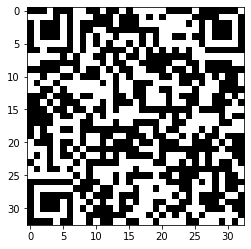

epoch 3 loss: 4.598


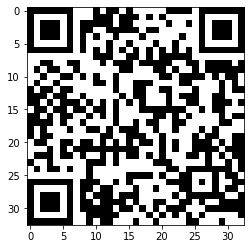

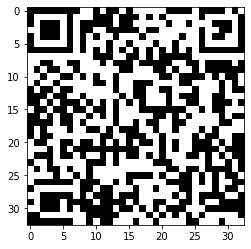

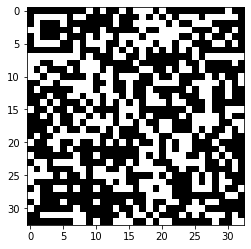

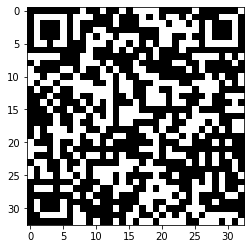

epoch 4 loss: 4.390


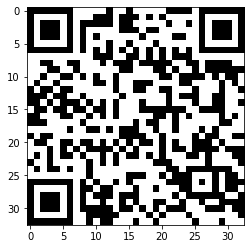

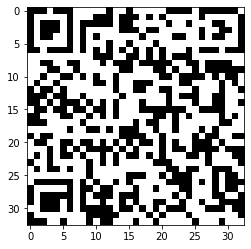

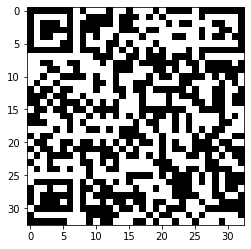

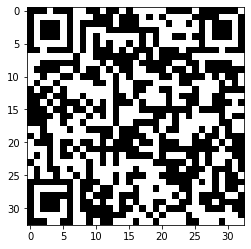

epoch 5 loss: 4.274


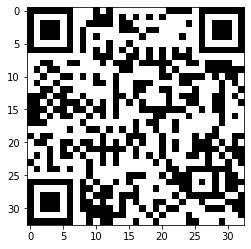

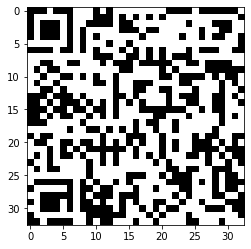

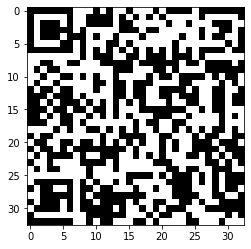

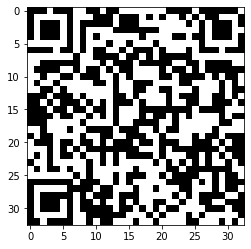

epoch 6 loss: 4.213


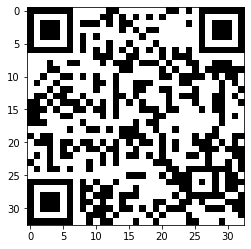

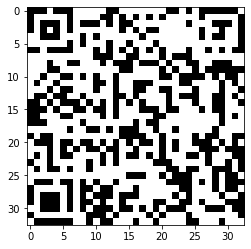

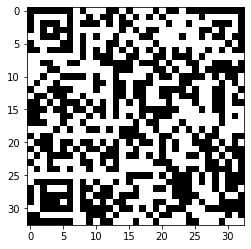

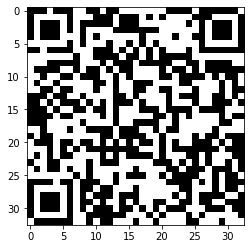

epoch 7 loss: 4.123


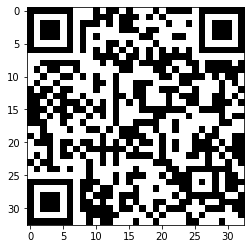

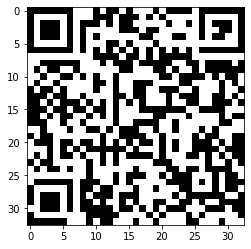

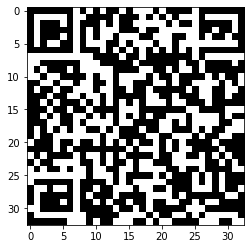

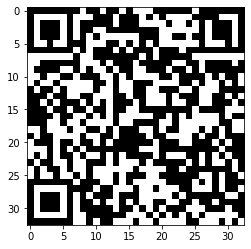

epoch 8 loss: 4.107


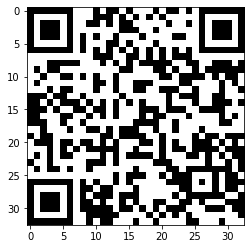

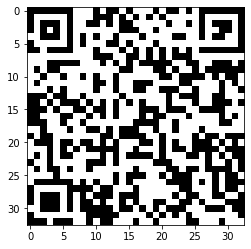

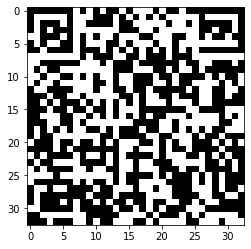

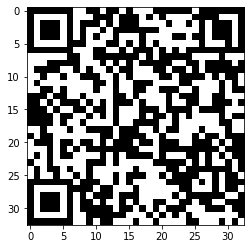

epoch 9 loss: 4.007


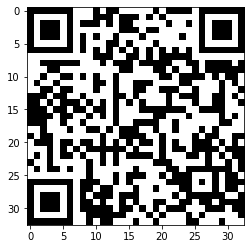

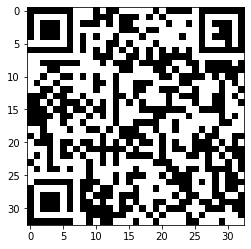

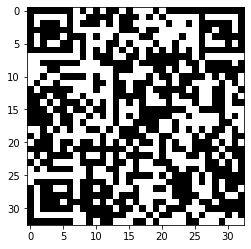

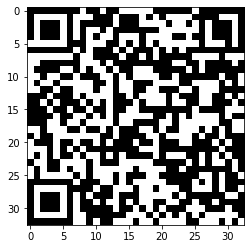

epoch 10 loss: 3.942


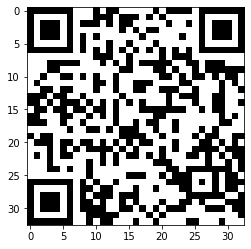

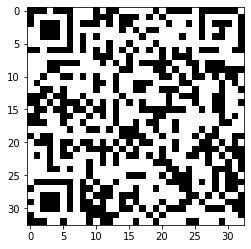

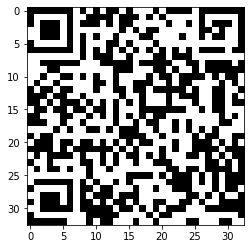

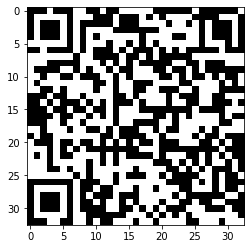

epoch 11 loss: 3.971


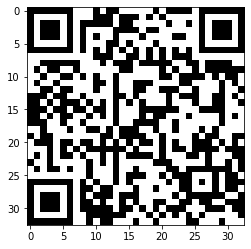

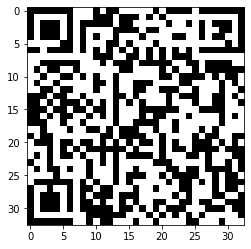

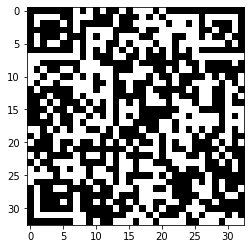

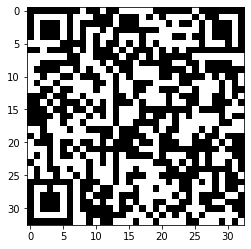

epoch 12 loss: 4.000


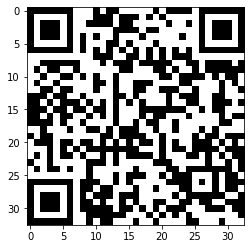

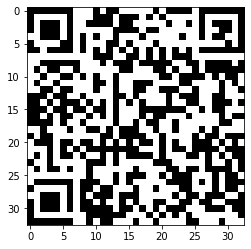

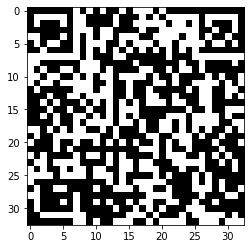

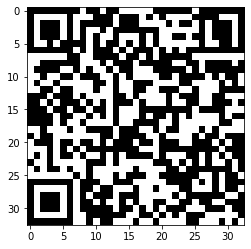

epoch 13 loss: 3.885


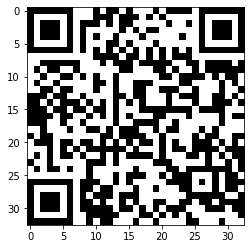

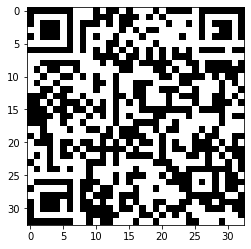

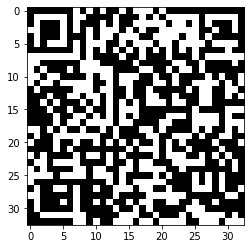

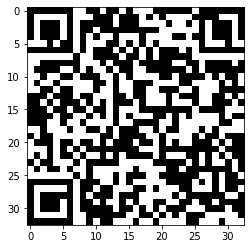

epoch 14 loss: 3.858


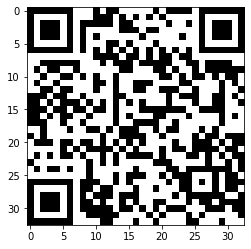

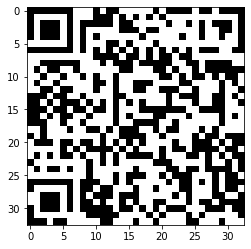

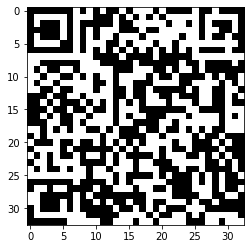

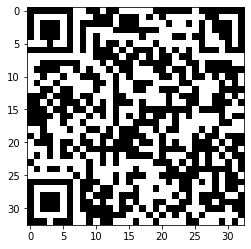

epoch 15 loss: 3.901


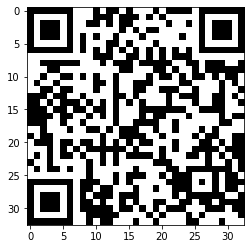

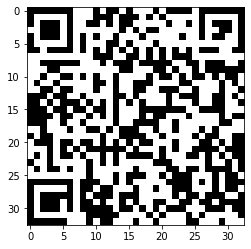

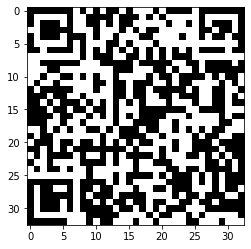

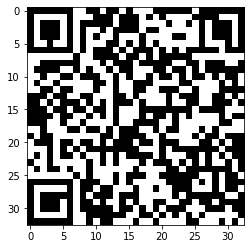

epoch 16 loss: 3.877


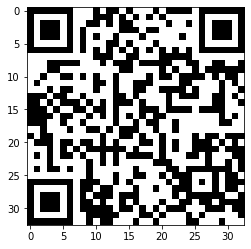

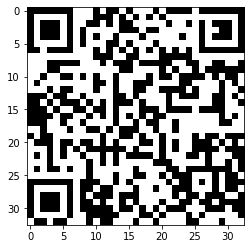

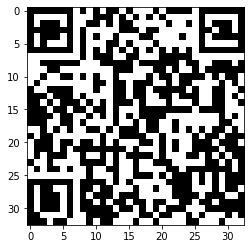

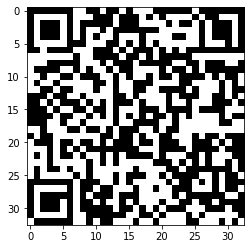

epoch 17 loss: 3.854


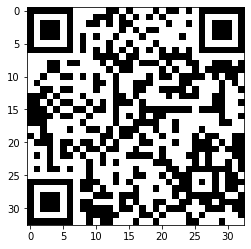

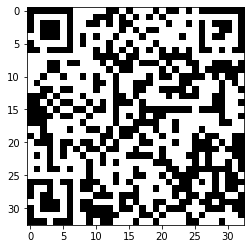

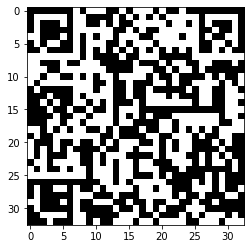

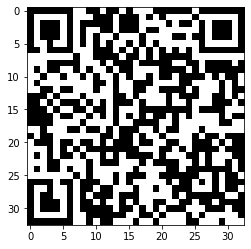

epoch 18 loss: 3.838


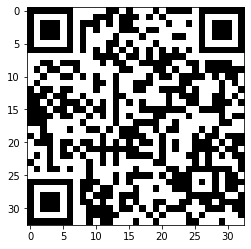

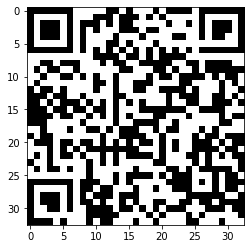

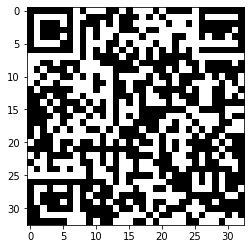

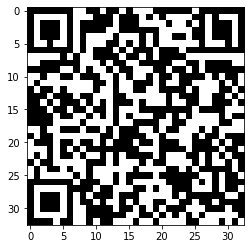

epoch 19 loss: 3.885


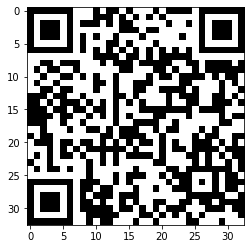

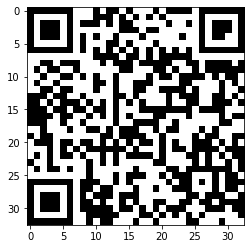

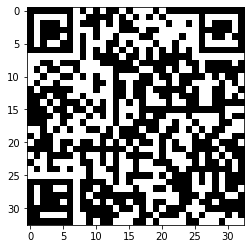

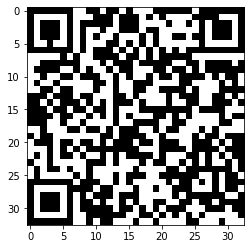

epoch 20 loss: 3.842


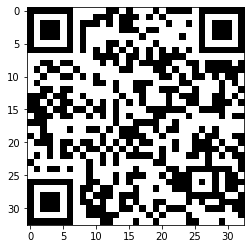

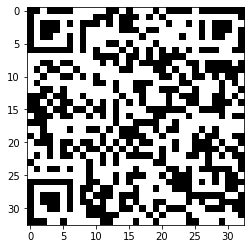

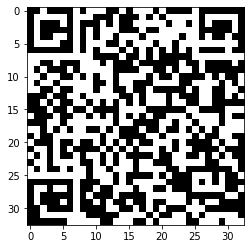

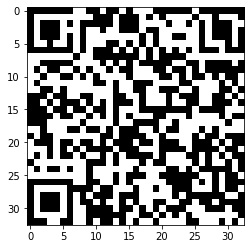

epoch 21 loss: 3.846


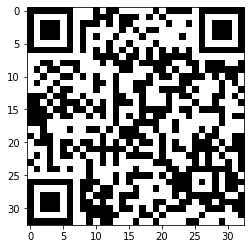

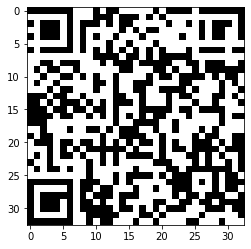

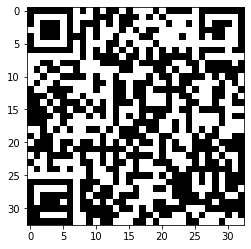

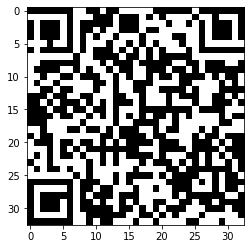

epoch 22 loss: 3.819


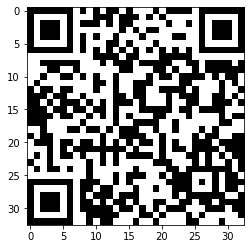

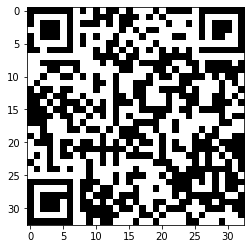

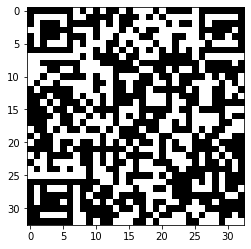

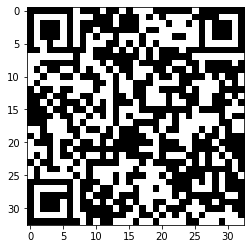

epoch 23 loss: 3.828


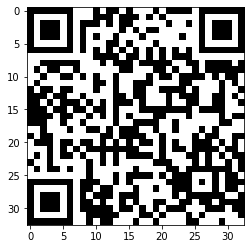

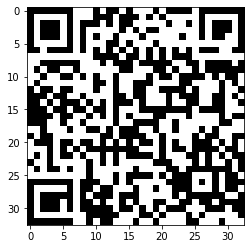

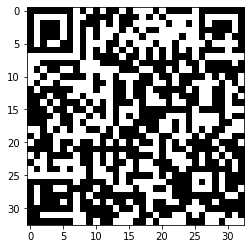

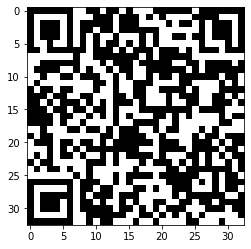

epoch 24 loss: 3.768


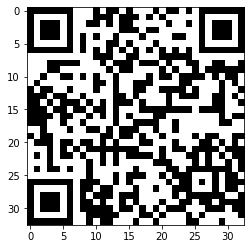

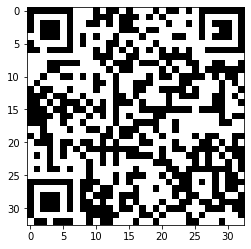

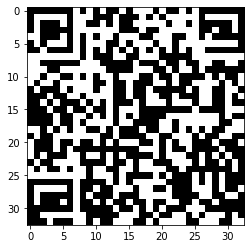

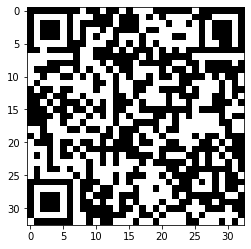

epoch 25 loss: 3.768


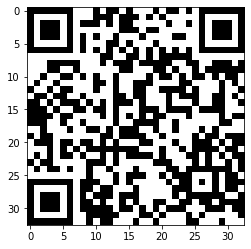

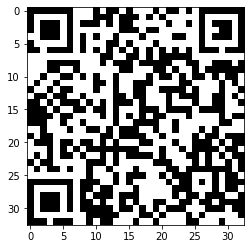

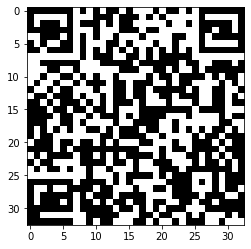

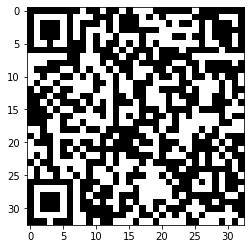

epoch 26 loss: 3.769


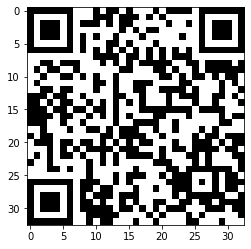

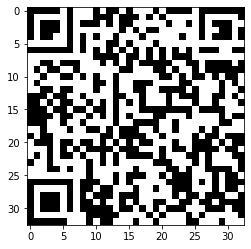

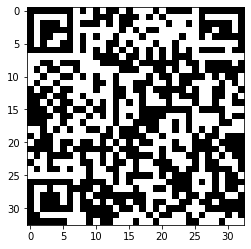

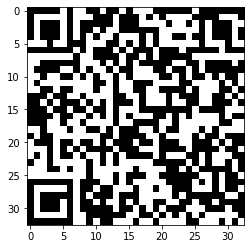

epoch 27 loss: 3.731


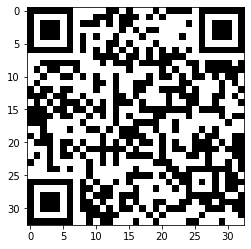

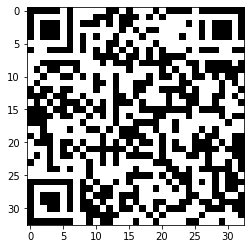

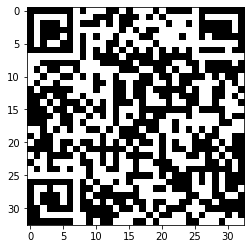

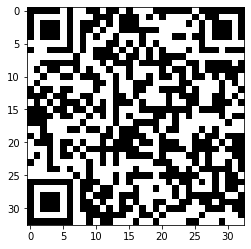

epoch 28 loss: 3.791


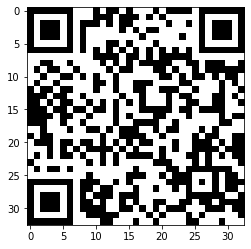

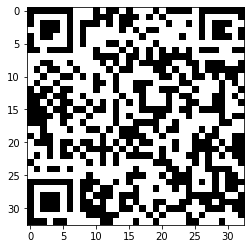

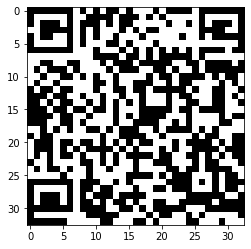

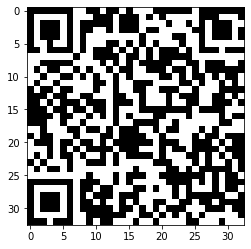

epoch 29 loss: 3.726


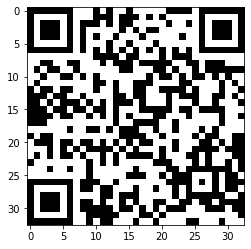

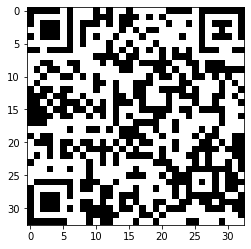

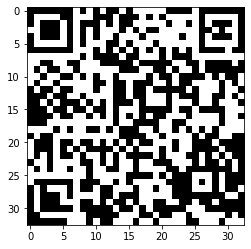

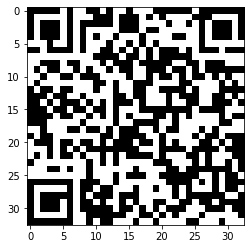

epoch 30 loss: 3.739


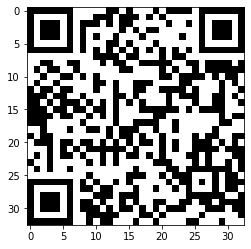

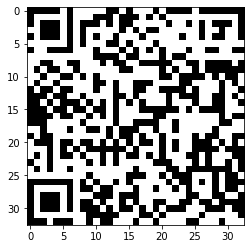

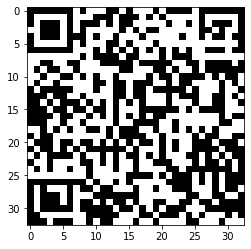

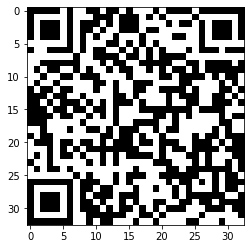

epoch 31 loss: 3.735


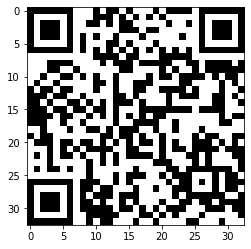

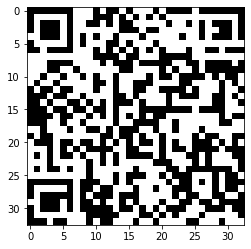

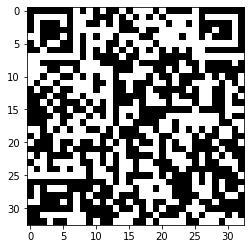

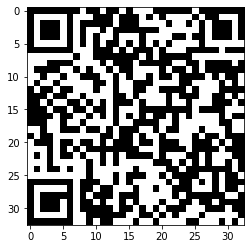

epoch 32 loss: 3.713


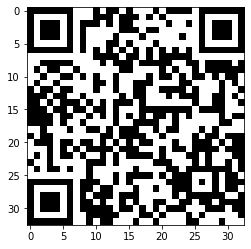

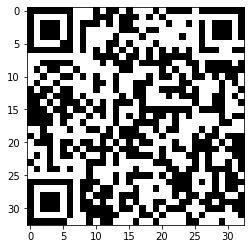

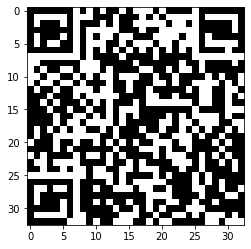

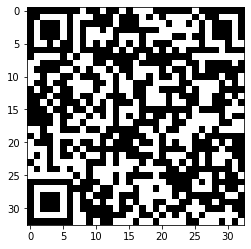

epoch 33 loss: 3.748


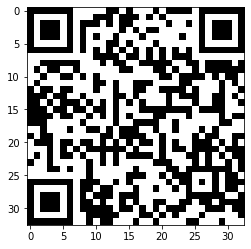

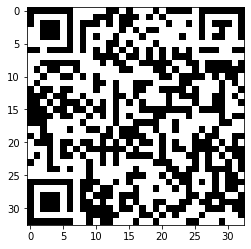

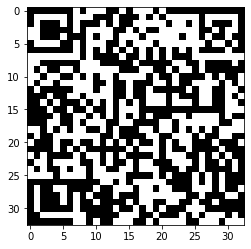

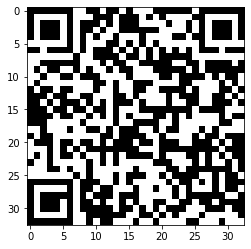

epoch 34 loss: 3.740


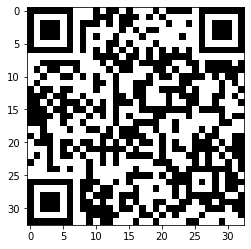

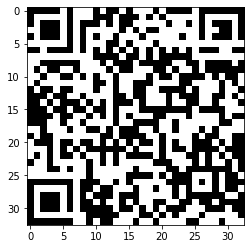

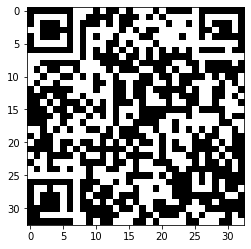

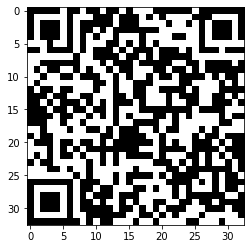

epoch 35 loss: 3.702


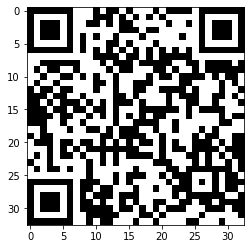

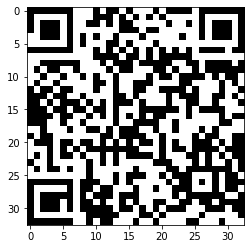

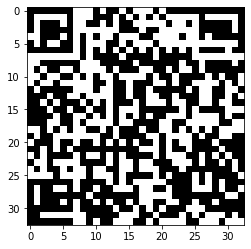

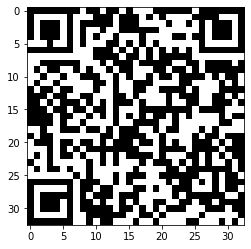

epoch 36 loss: 3.714


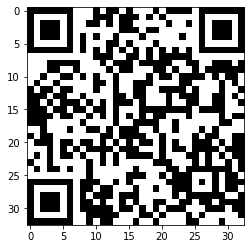

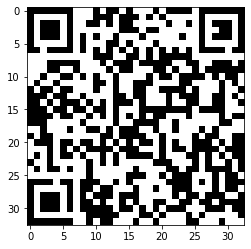

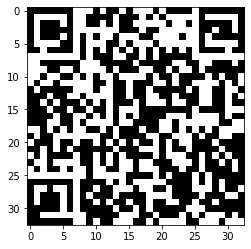

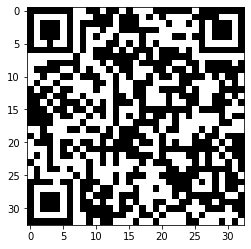

epoch 37 loss: 3.691


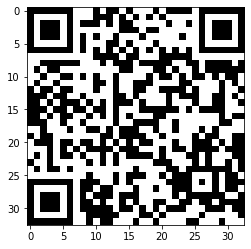

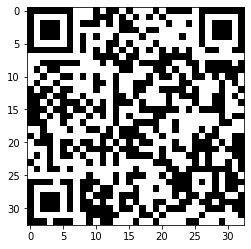

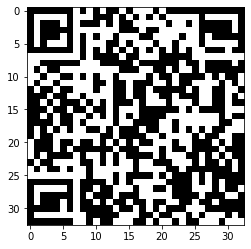

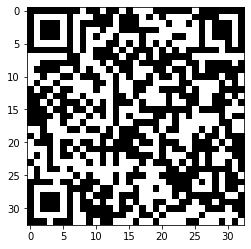

epoch 38 loss: 3.723


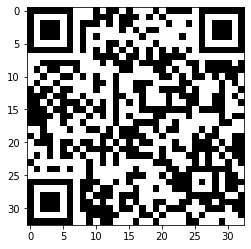

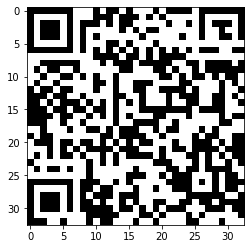

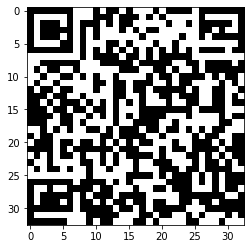

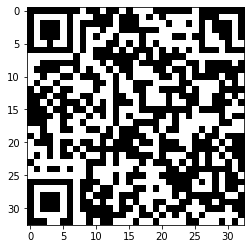

epoch 39 loss: 3.716


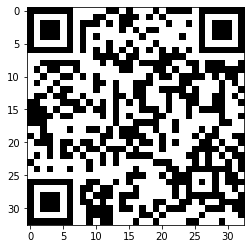

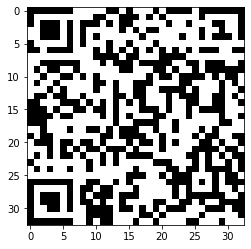

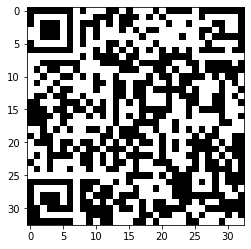

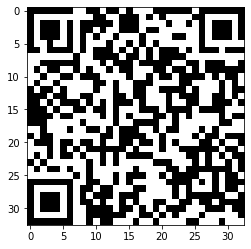

epoch 40 loss: 3.710


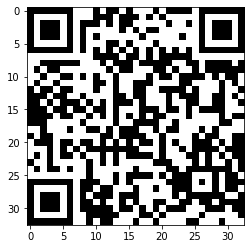

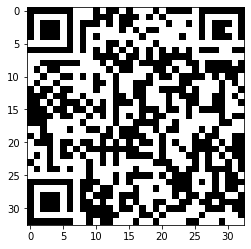

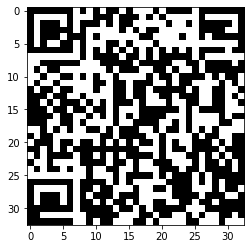

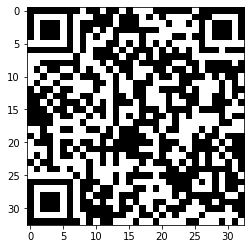

epoch 41 loss: 3.669


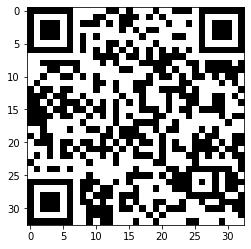

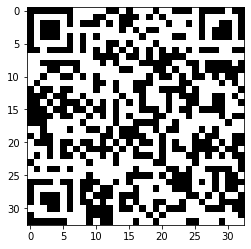

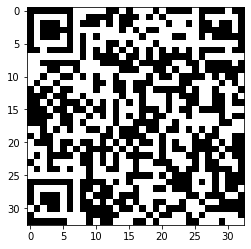

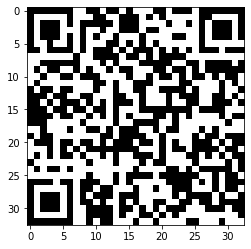

epoch 42 loss: 3.682


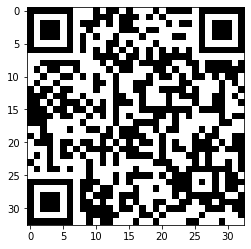

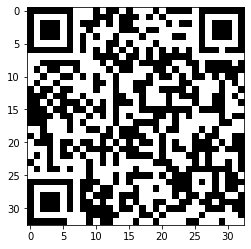

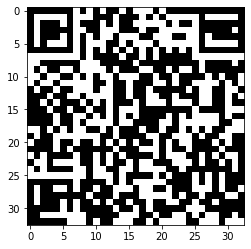

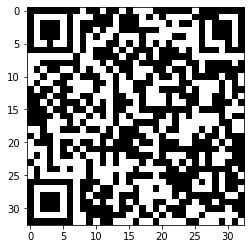

epoch 43 loss: 3.734


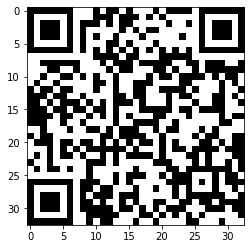

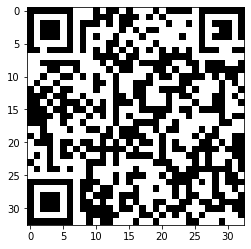

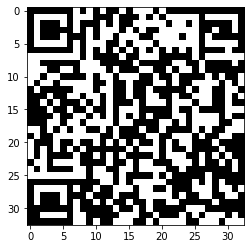

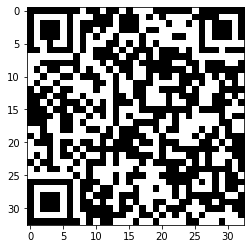

epoch 44 loss: 3.642


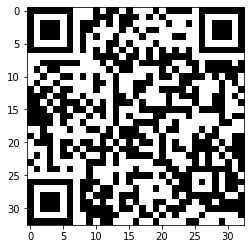

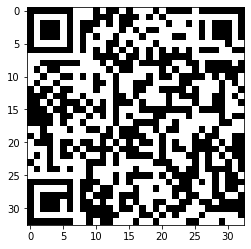

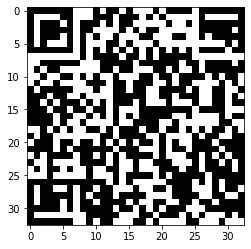

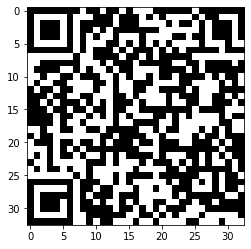

epoch 45 loss: 3.665


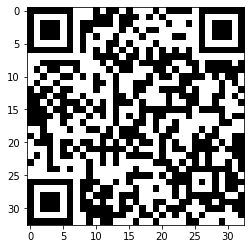

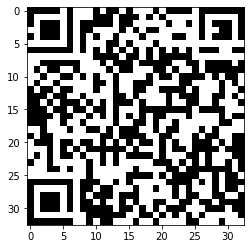

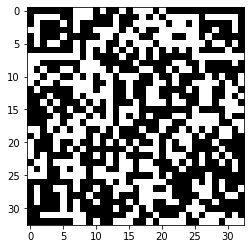

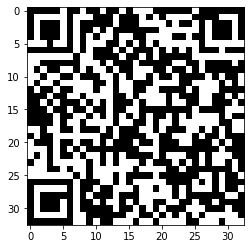

epoch 46 loss: 3.638


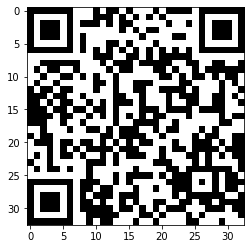

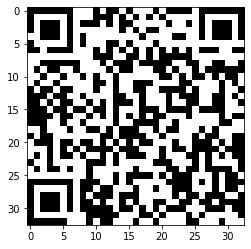

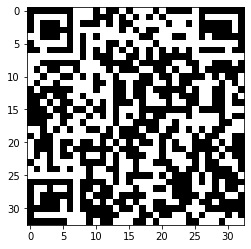

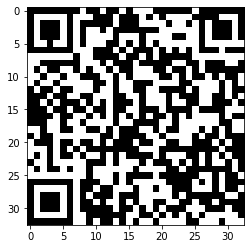

epoch 47 loss: 3.651


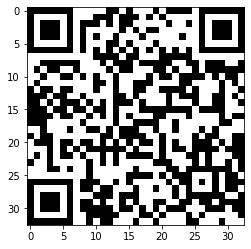

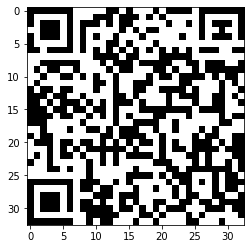

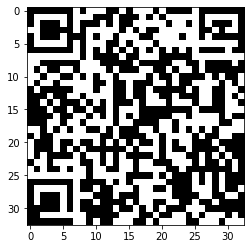

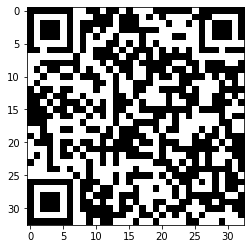

epoch 48 loss: 3.608


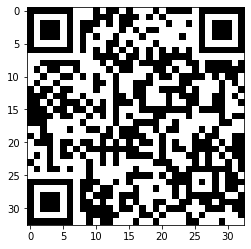

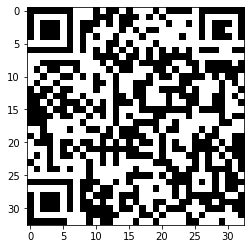

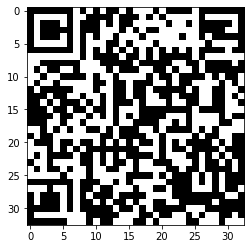

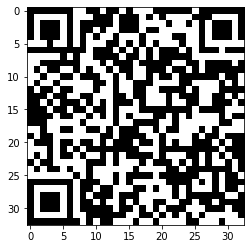

epoch 49 loss: 3.630


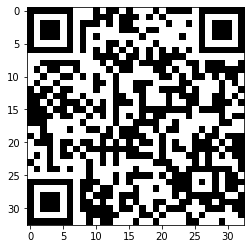

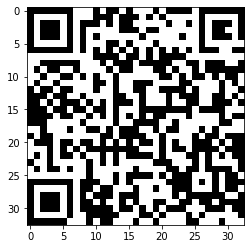

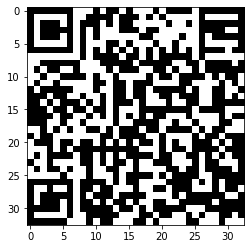

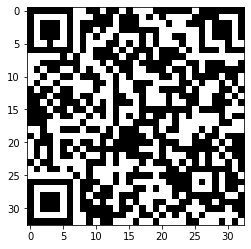

epoch 50 loss: 3.623


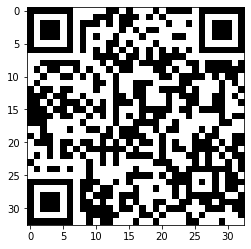

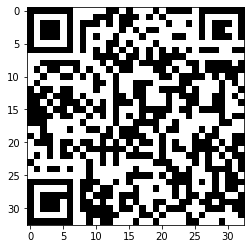

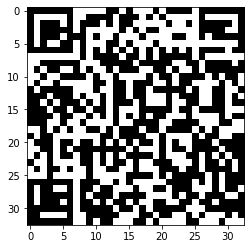

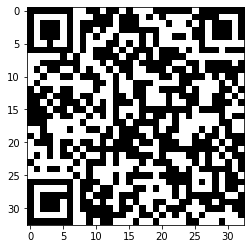

epoch 51 loss: 3.648


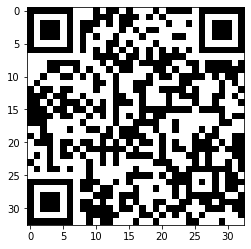

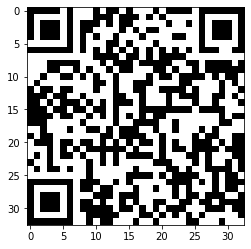

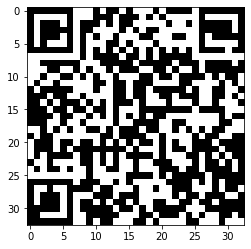

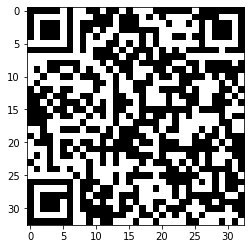

epoch 52 loss: 3.652


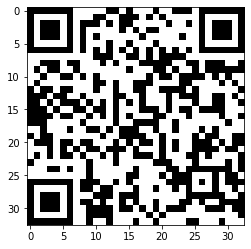

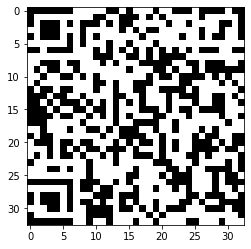

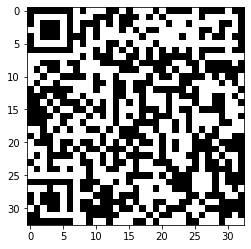

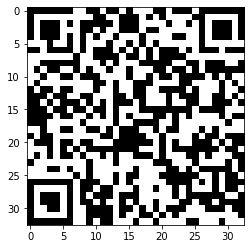

epoch 53 loss: 3.626


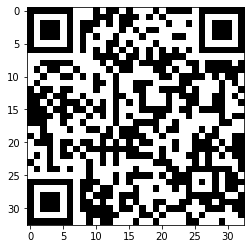

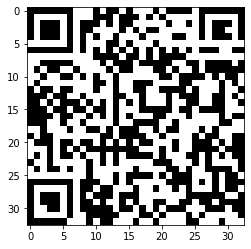

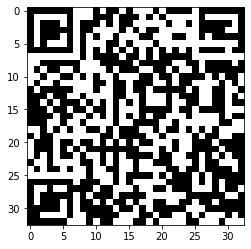

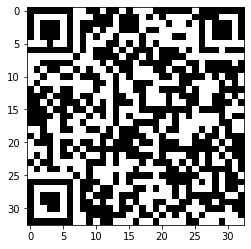

epoch 54 loss: 3.633


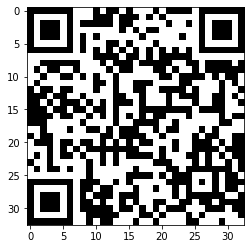

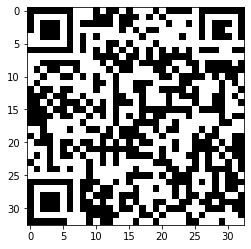

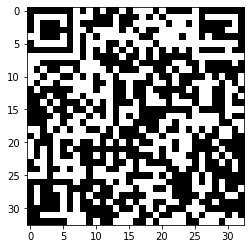

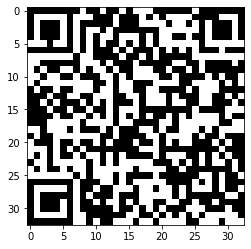

epoch 55 loss: 3.604


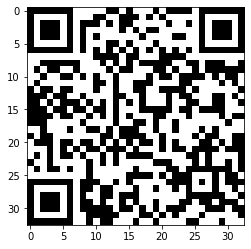

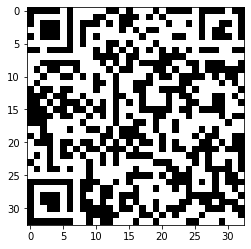

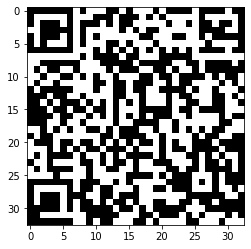

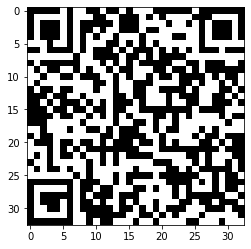

epoch 56 loss: 3.646


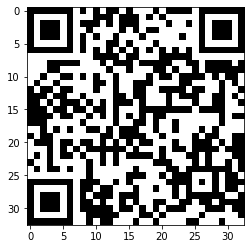

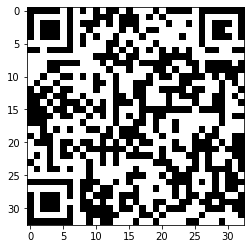

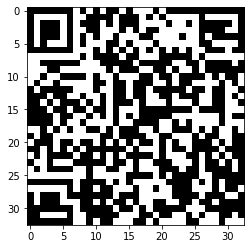

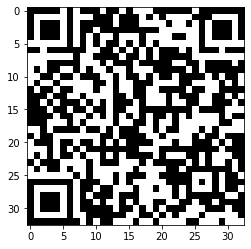

epoch 57 loss: 3.608


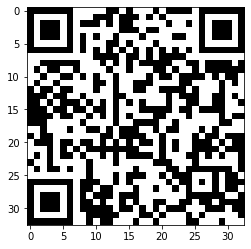

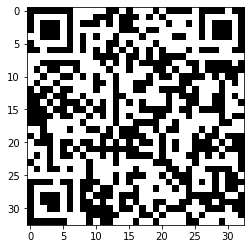

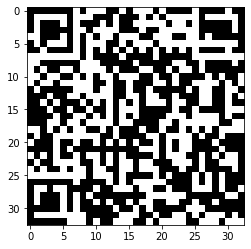

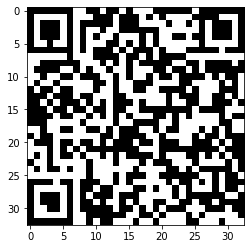

epoch 58 loss: 3.605


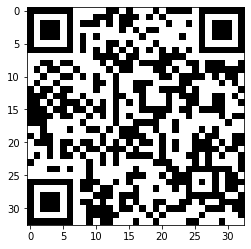

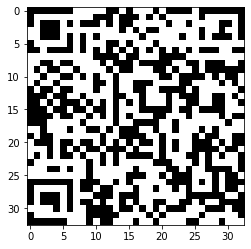

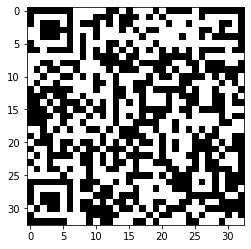

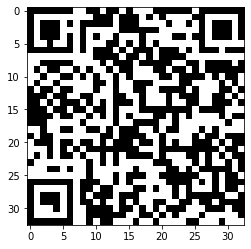

epoch 59 loss: 3.646


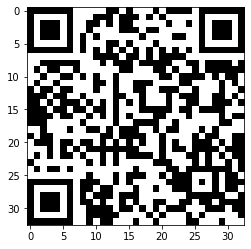

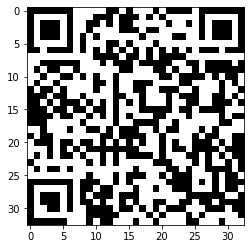

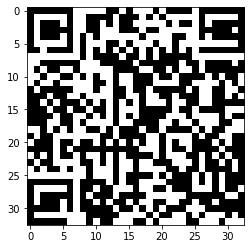

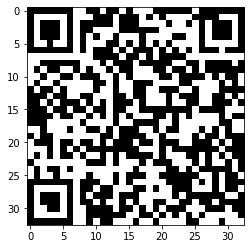

epoch 60 loss: 3.651


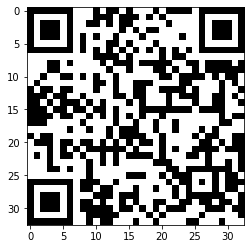

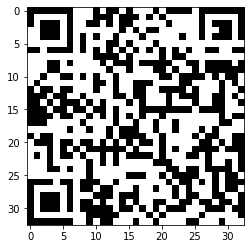

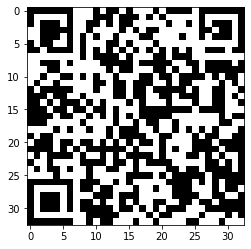

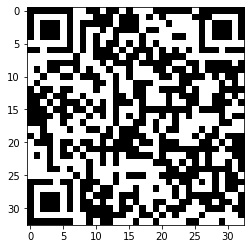

epoch 61 loss: 3.589


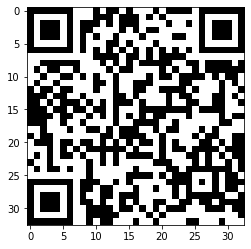

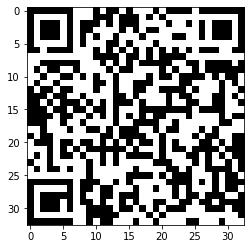

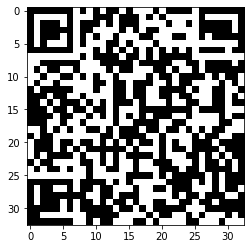

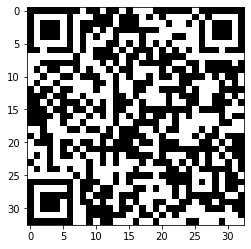

epoch 62 loss: 3.583


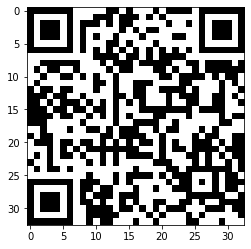

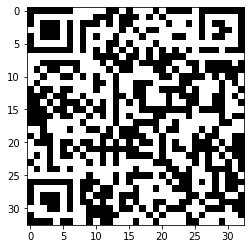

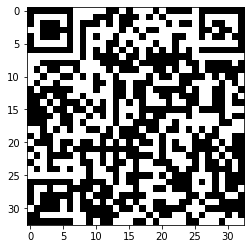

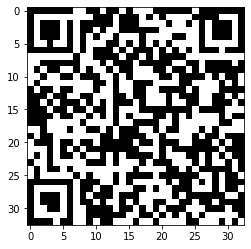

epoch 63 loss: 3.594


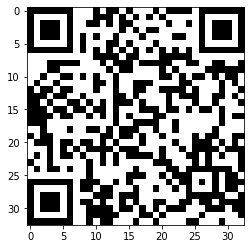

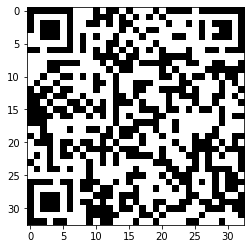

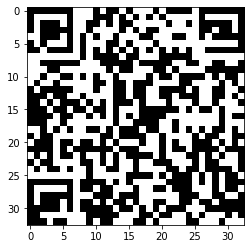

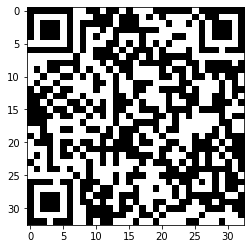

epoch 64 loss: 3.584


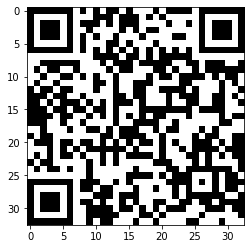

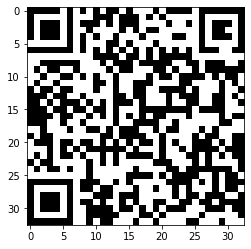

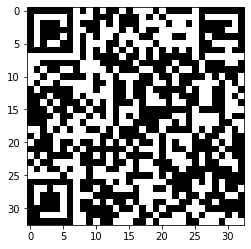

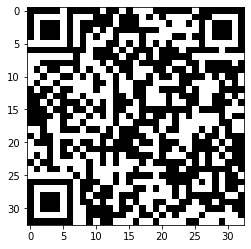

epoch 65 loss: 3.583


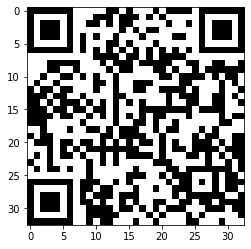

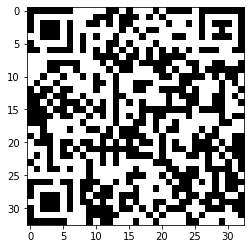

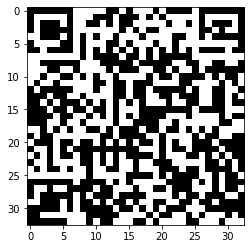

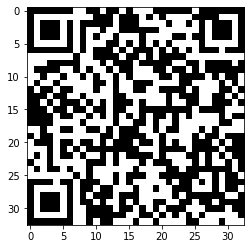

epoch 66 loss: 3.569


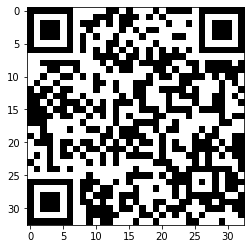

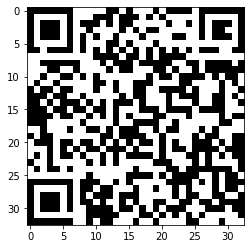

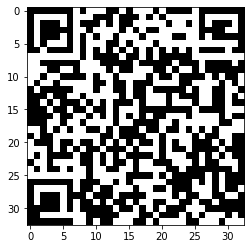

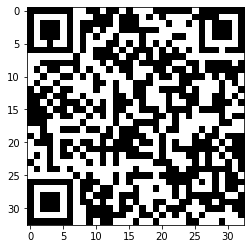

epoch 67 loss: 3.612


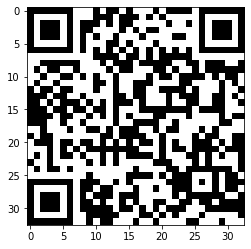

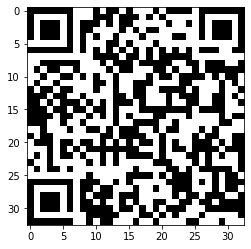

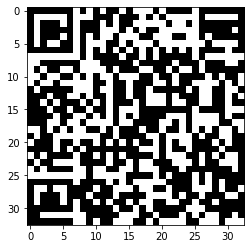

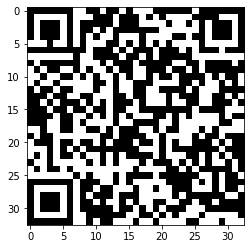

epoch 68 loss: 3.548


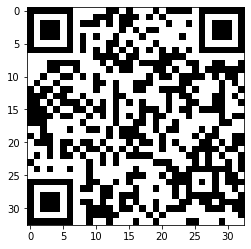

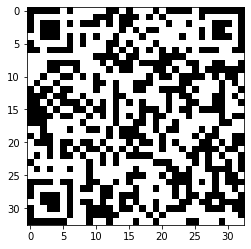

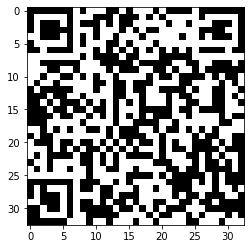

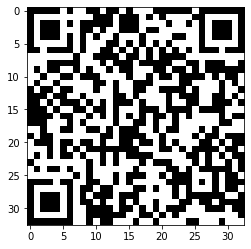

epoch 69 loss: 3.544


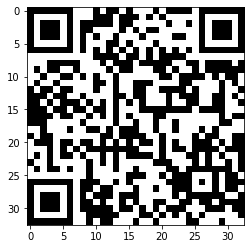

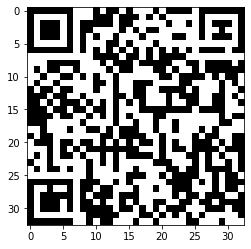

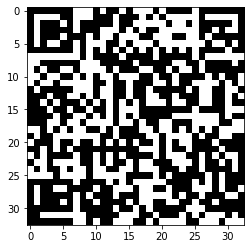

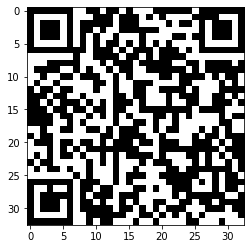

epoch 70 loss: 3.555


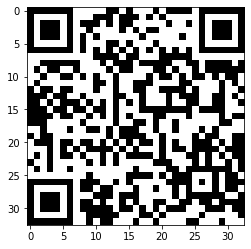

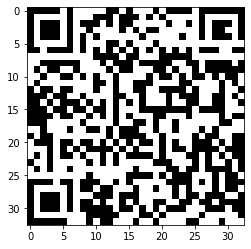

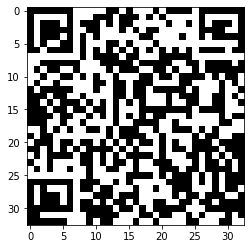

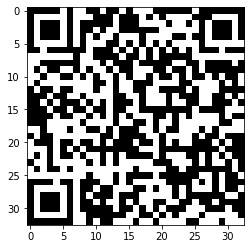

epoch 71 loss: 3.571


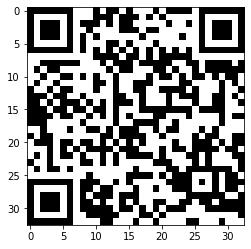

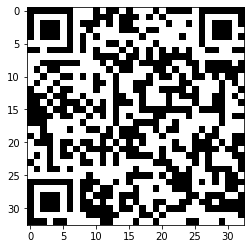

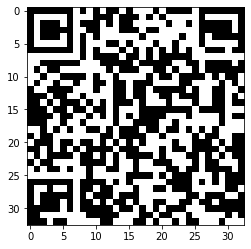

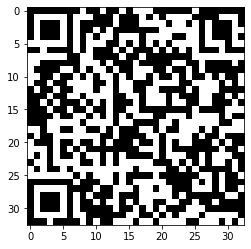

epoch 72 loss: 3.550


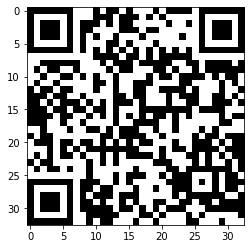

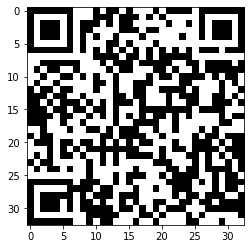

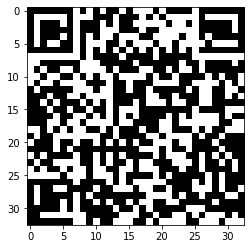

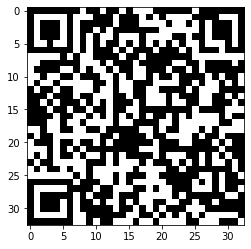

epoch 73 loss: 3.576


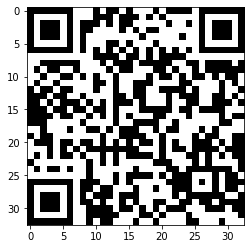

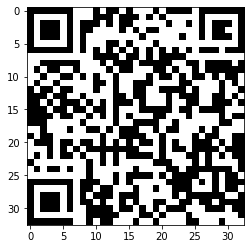

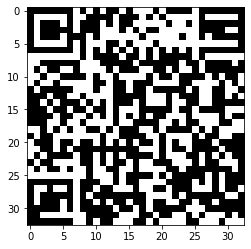

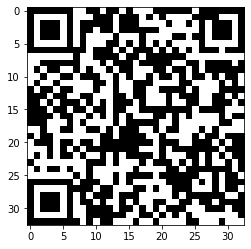

epoch 74 loss: 3.542


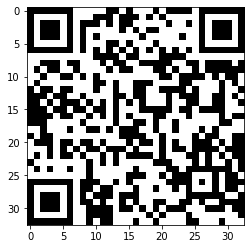

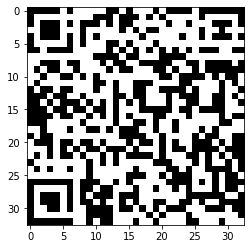

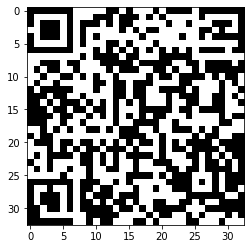

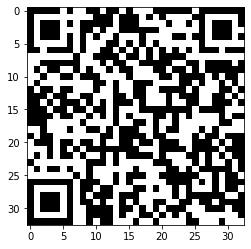

epoch 75 loss: 3.574


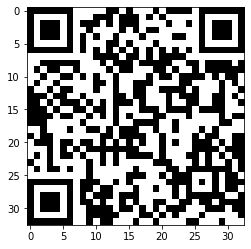

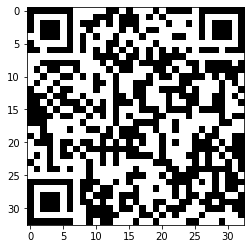

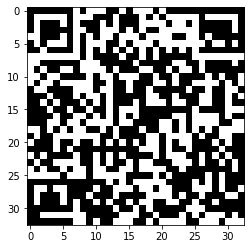

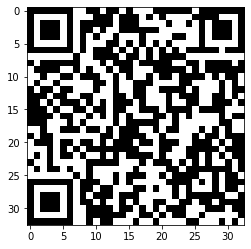

epoch 76 loss: 3.567


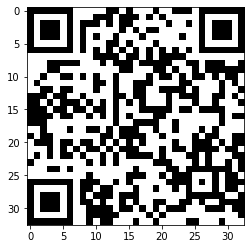

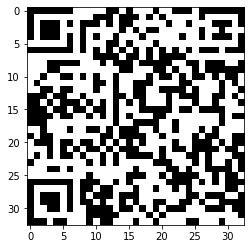

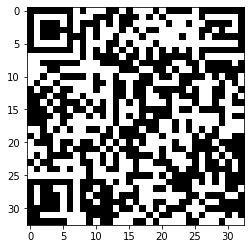

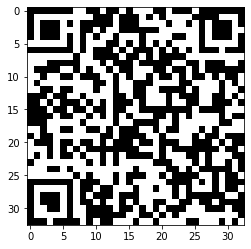

epoch 77 loss: 3.516


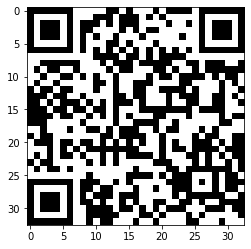

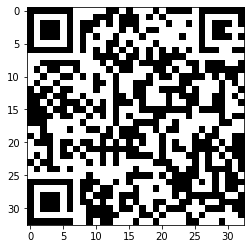

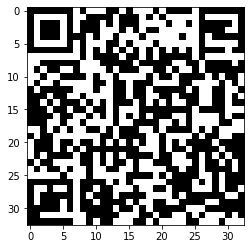

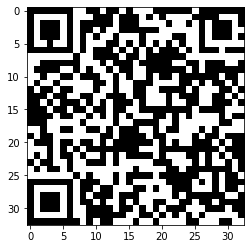

epoch 78 loss: 3.590


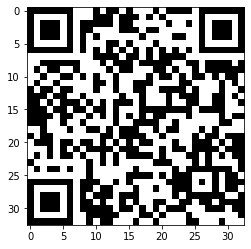

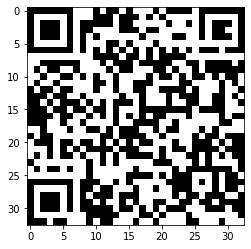

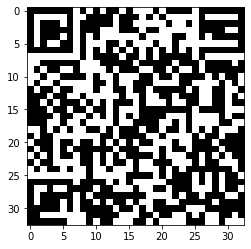

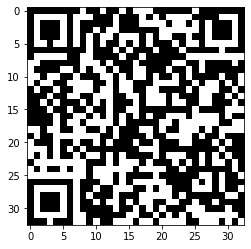

epoch 79 loss: 3.572


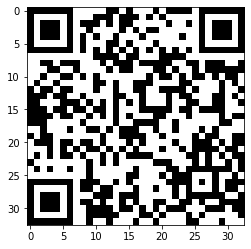

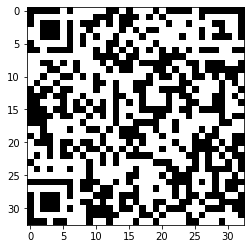

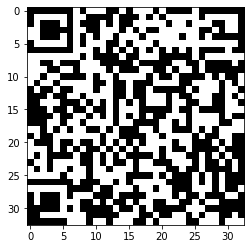

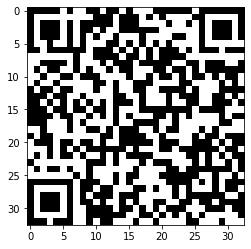

epoch 80 loss: 3.531


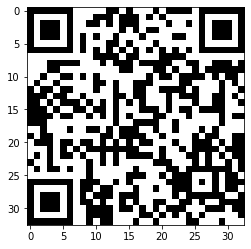

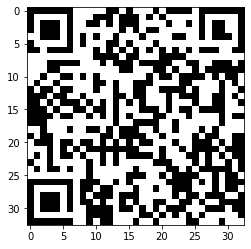

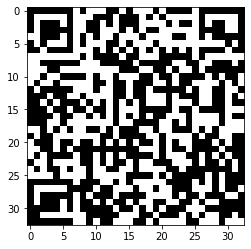

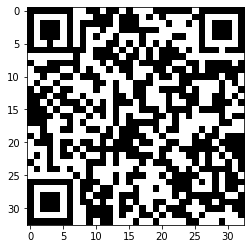

epoch 81 loss: 3.506


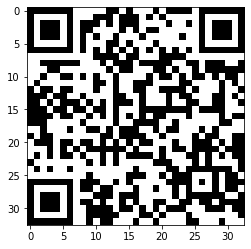

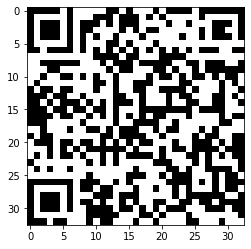

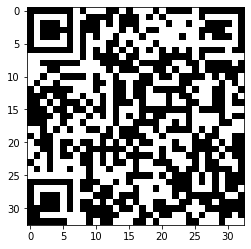

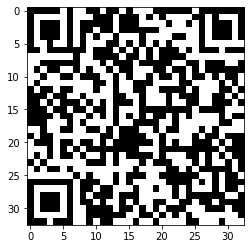

epoch 82 loss: 3.574


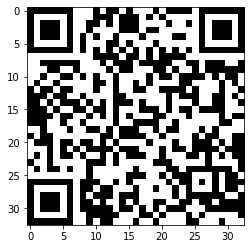

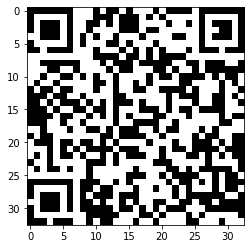

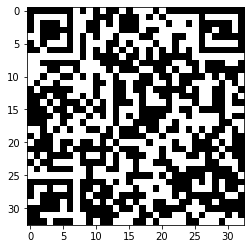

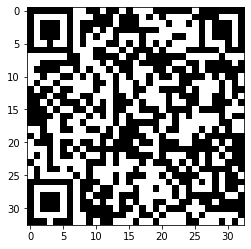

epoch 83 loss: 3.554


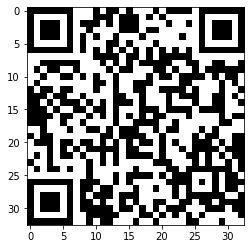

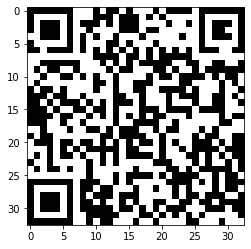

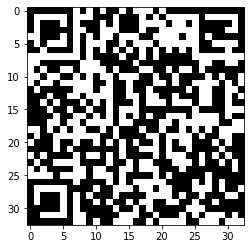

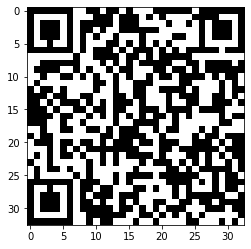

epoch 84 loss: 3.511


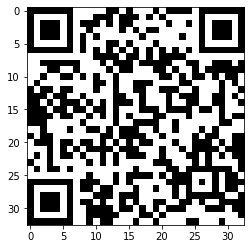

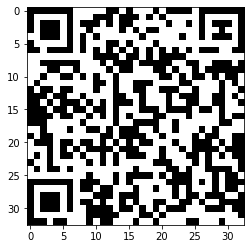

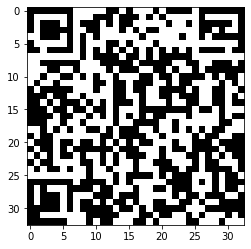

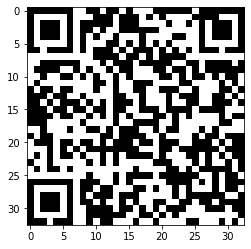

epoch 85 loss: 3.581


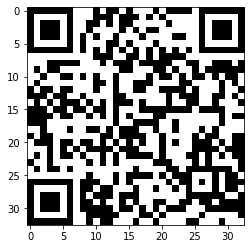

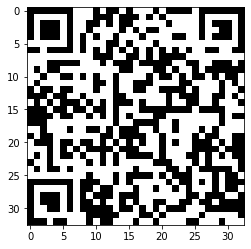

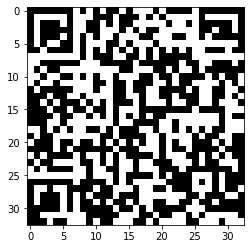

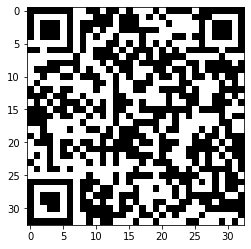

epoch 86 loss: 3.522


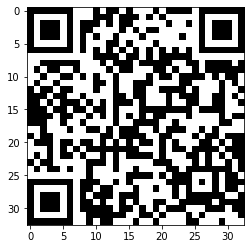

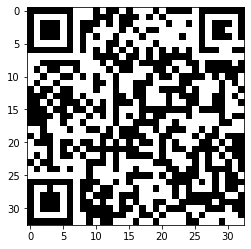

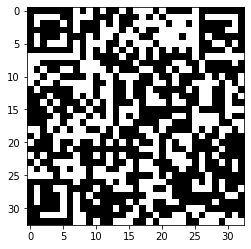

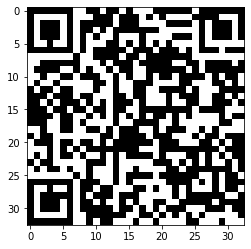

epoch 87 loss: 3.525


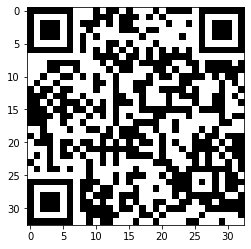

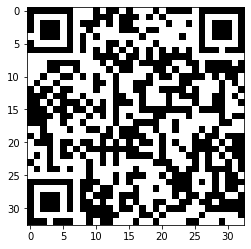

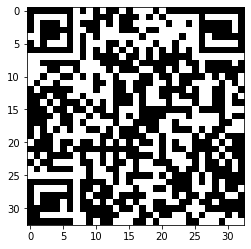

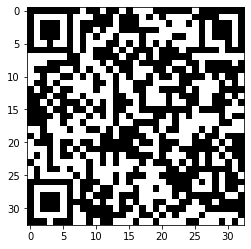

epoch 88 loss: 3.530


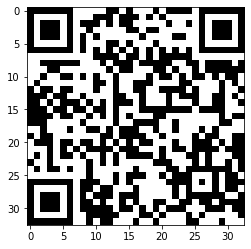

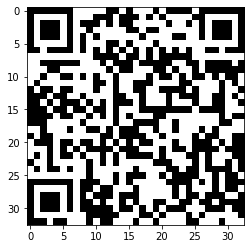

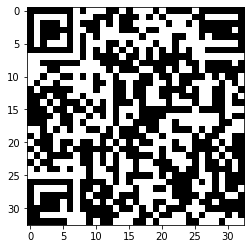

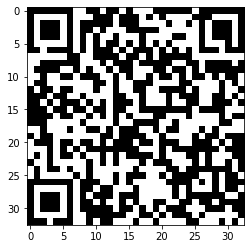

epoch 89 loss: 3.505


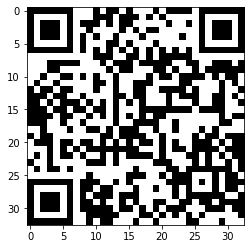

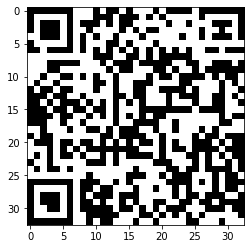

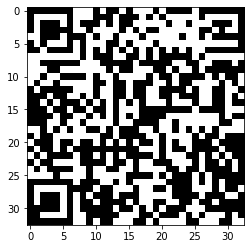

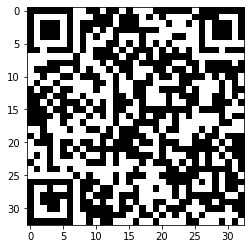

epoch 90 loss: 3.496


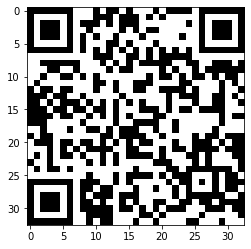

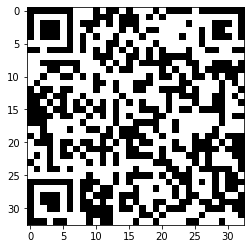

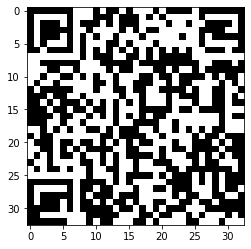

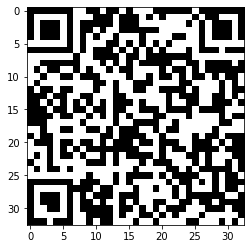

epoch 91 loss: 3.496


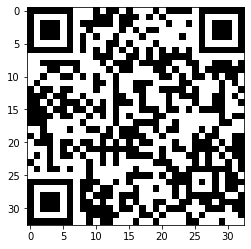

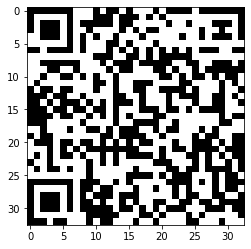

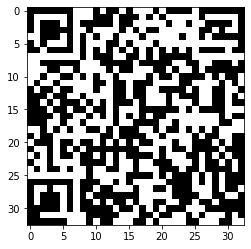

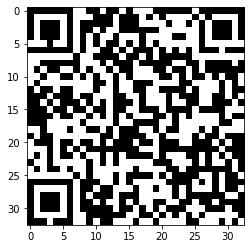

epoch 92 loss: 3.514


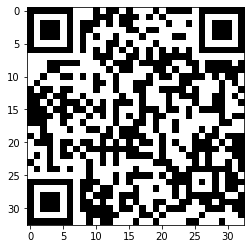

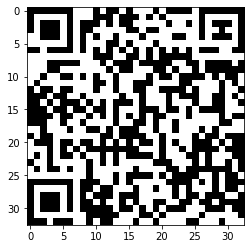

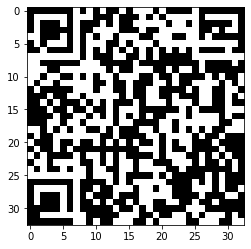

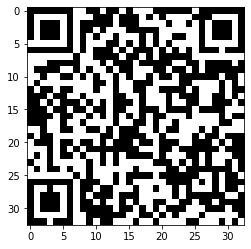

epoch 93 loss: 3.506


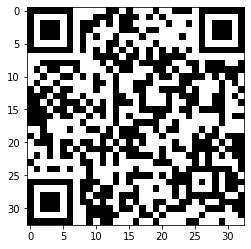

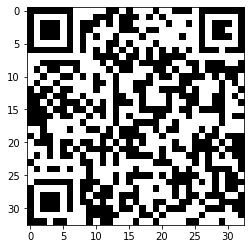

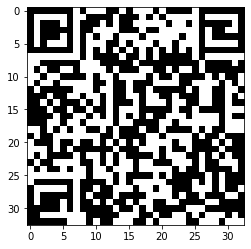

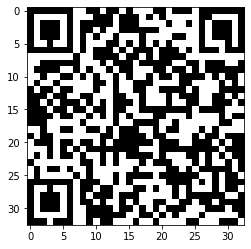

epoch 94 loss: 3.503


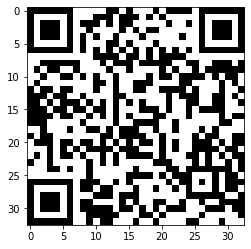

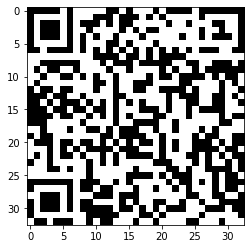

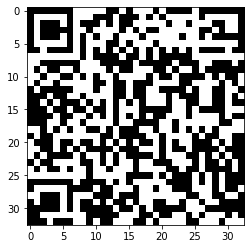

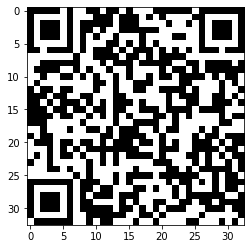

epoch 95 loss: 3.477


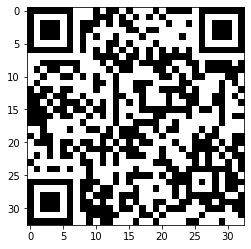

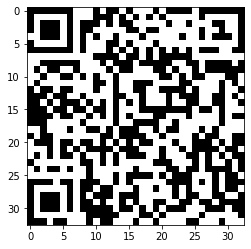

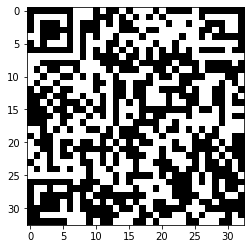

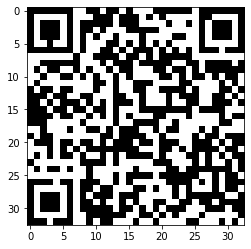

epoch 96 loss: 3.502


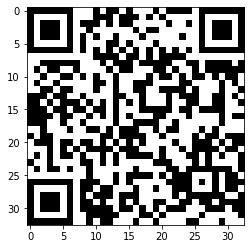

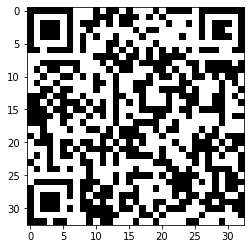

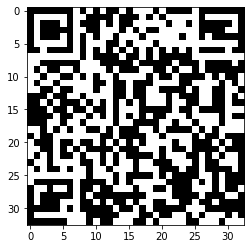

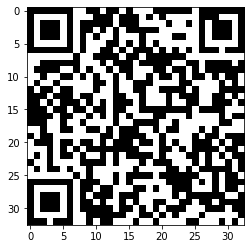

epoch 97 loss: 3.513


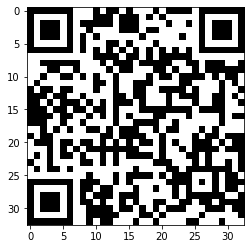

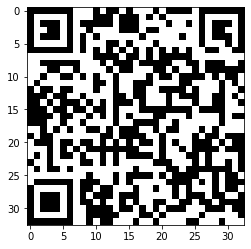

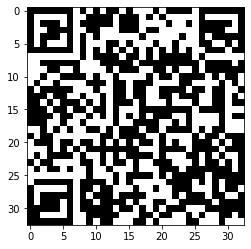

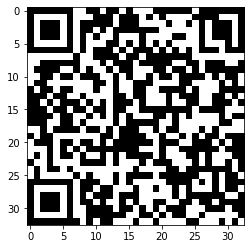

epoch 98 loss: 3.505


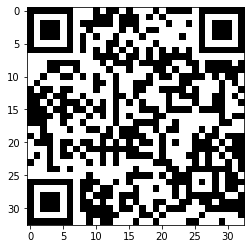

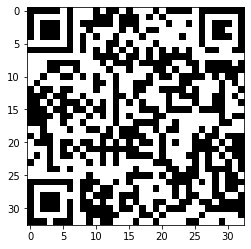

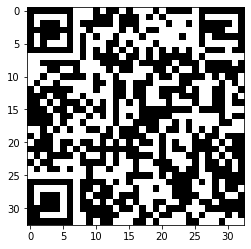

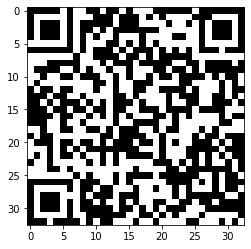

epoch 99 loss: 3.490


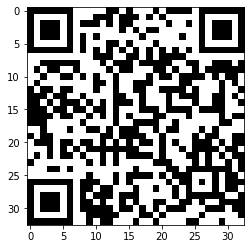

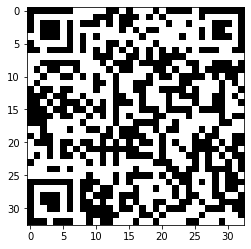

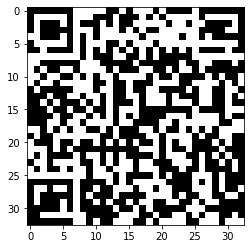

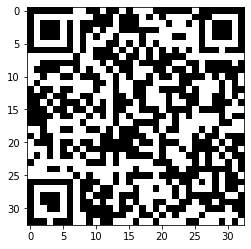

epoch 100 loss: 3.507


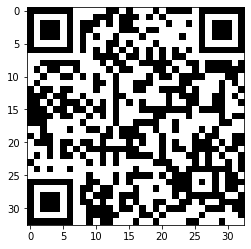

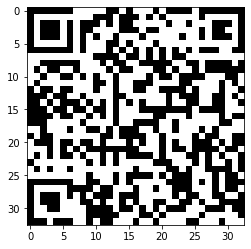

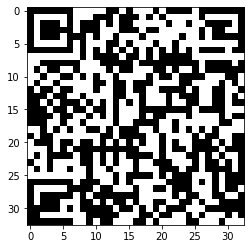

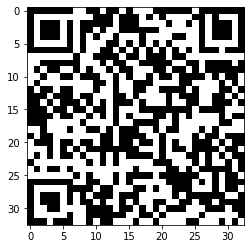

epoch 101 loss: 3.507


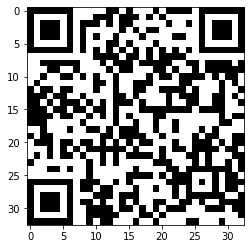

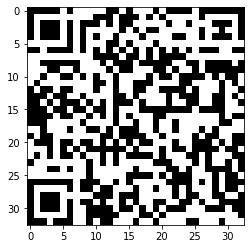

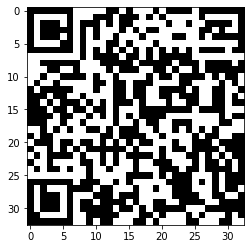

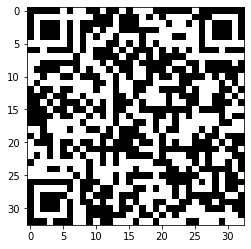

epoch 102 loss: 3.488


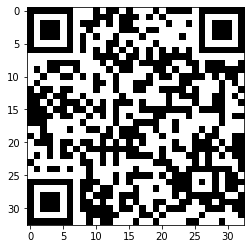

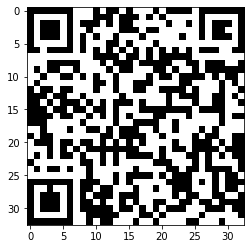

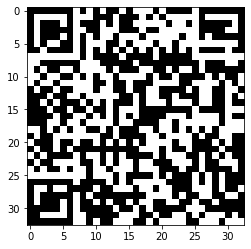

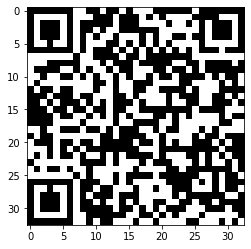

epoch 103 loss: 3.478


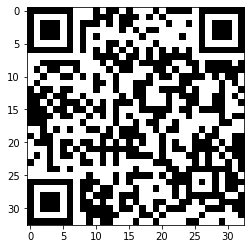

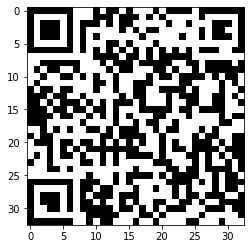

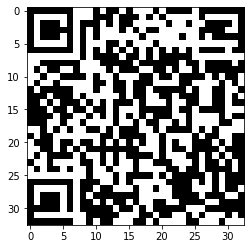

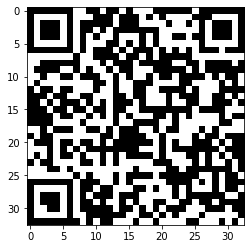

epoch 104 loss: 3.486


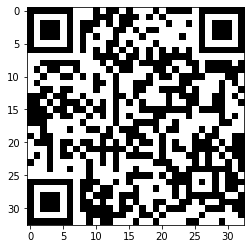

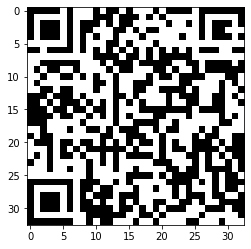

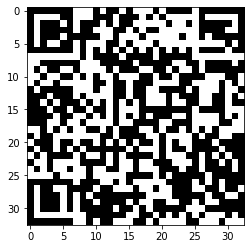

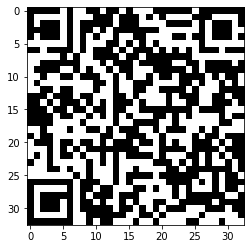

epoch 105 loss: 3.522


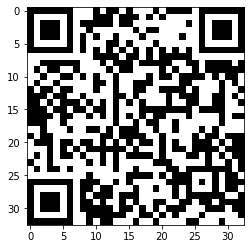

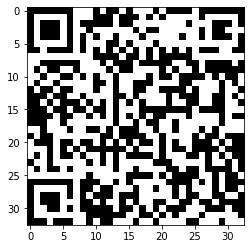

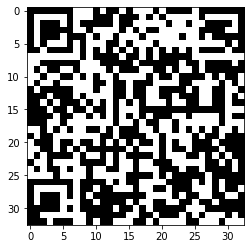

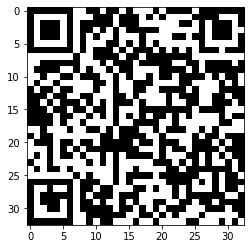

epoch 106 loss: 3.529


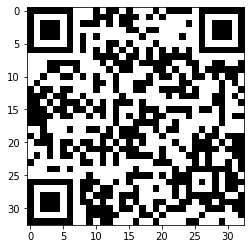

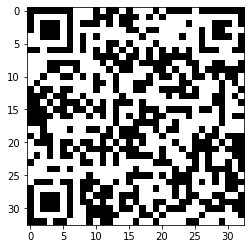

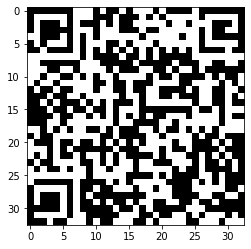

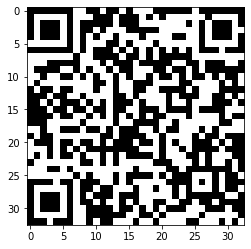

epoch 107 loss: 3.518


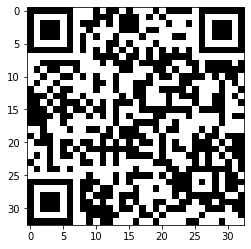

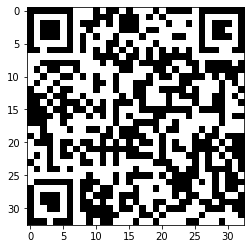

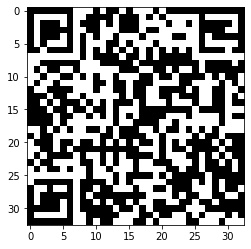

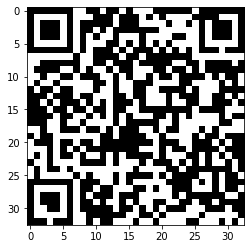

epoch 108 loss: 3.465


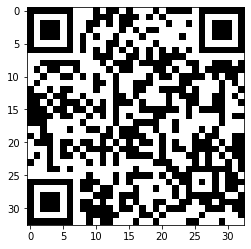

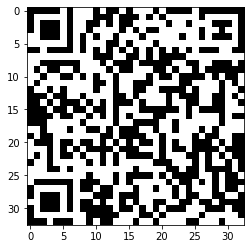

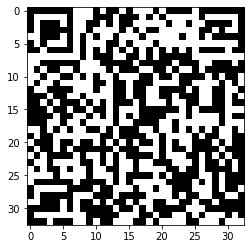

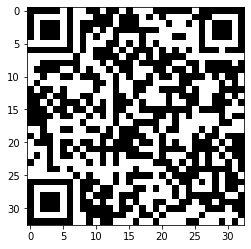

epoch 109 loss: 3.487


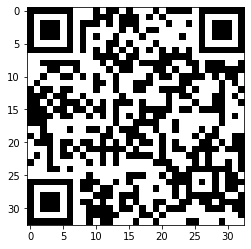

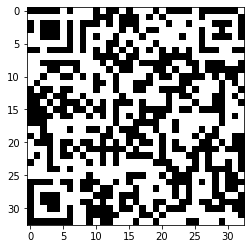

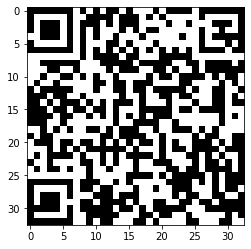

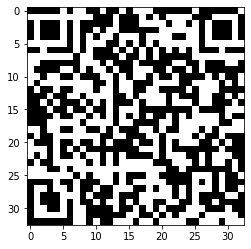

epoch 110 loss: 3.497


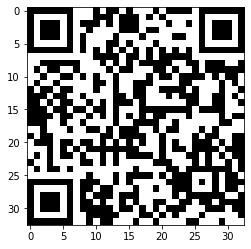

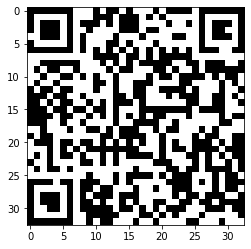

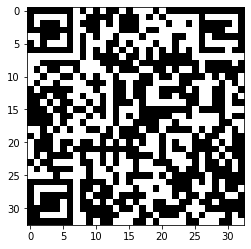

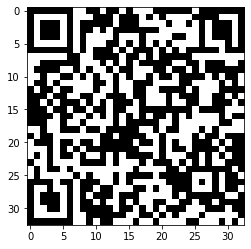

epoch 111 loss: 3.449


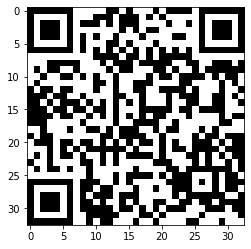

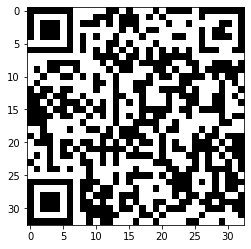

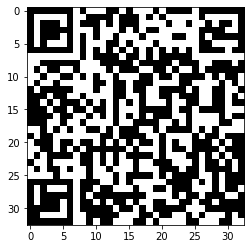

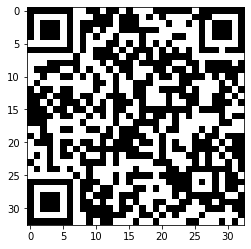

epoch 112 loss: 3.471


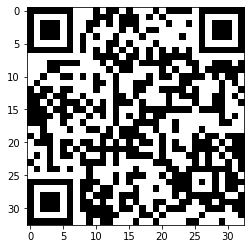

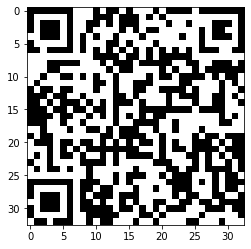

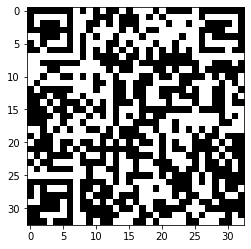

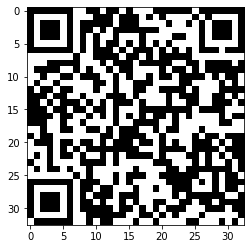

epoch 113 loss: 3.459


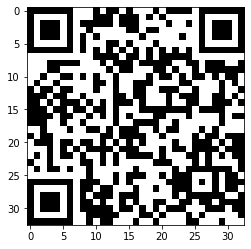

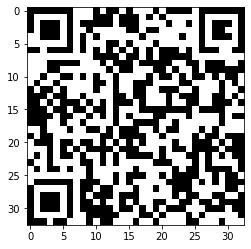

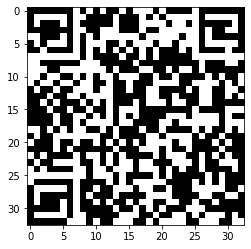

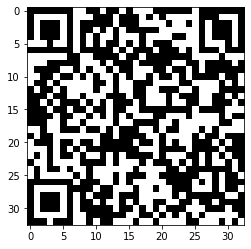

epoch 114 loss: 3.522


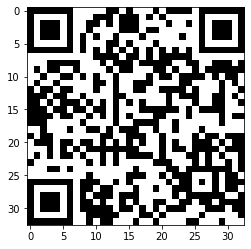

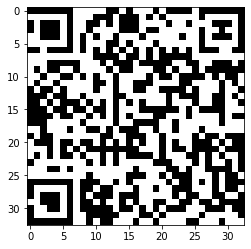

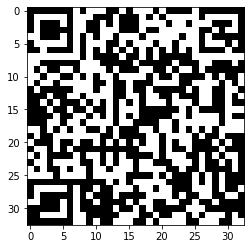

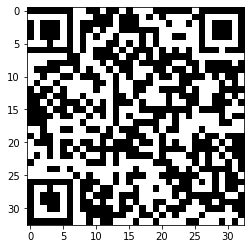

epoch 115 loss: 3.472


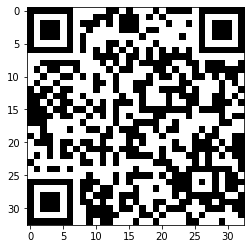

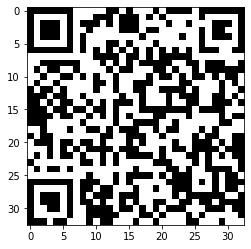

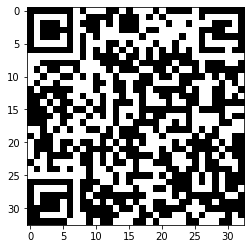

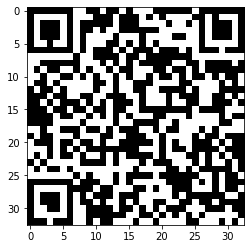

epoch 116 loss: 3.470


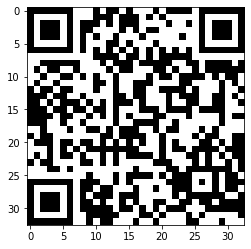

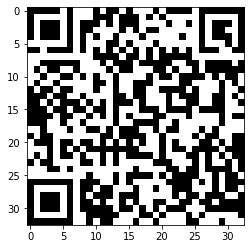

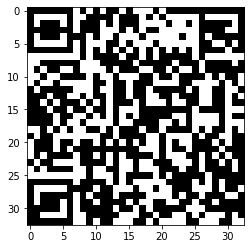

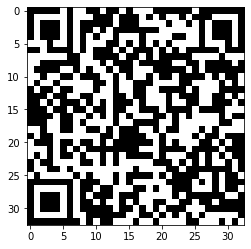

epoch 117 loss: 3.467


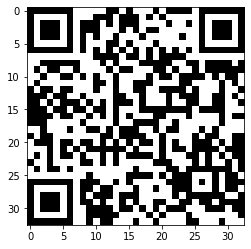

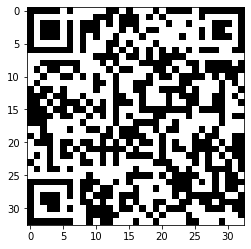

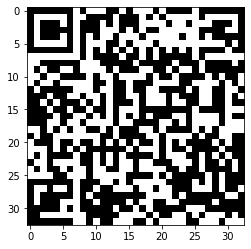

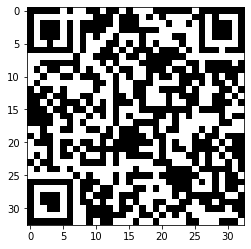

epoch 118 loss: 3.459


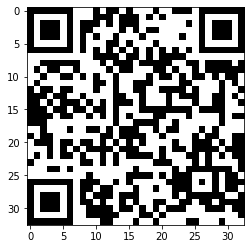

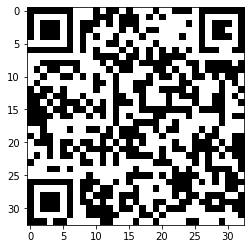

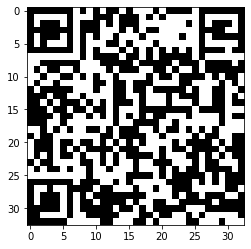

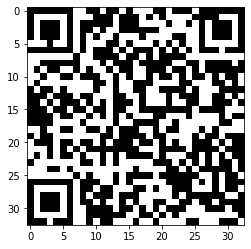

epoch 119 loss: 3.459


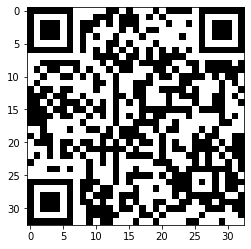

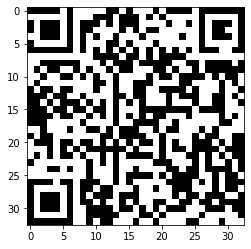

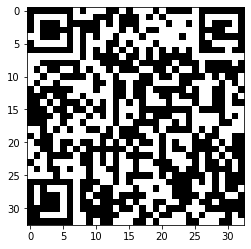

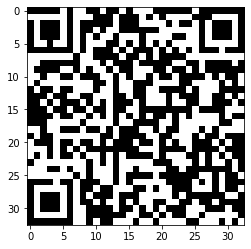

epoch 120 loss: 3.483


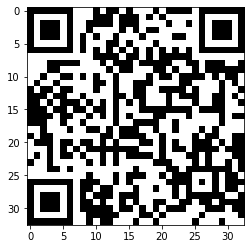

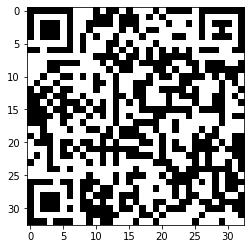

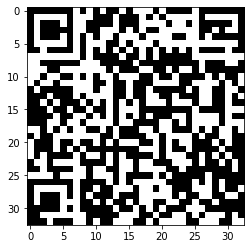

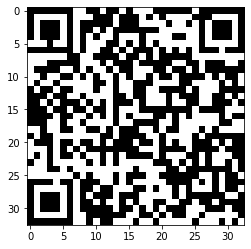

epoch 121 loss: 3.435


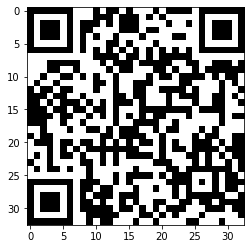

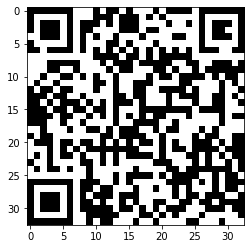

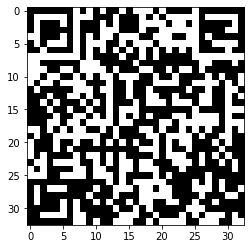

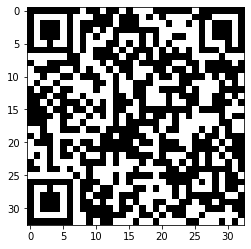

epoch 122 loss: 3.439


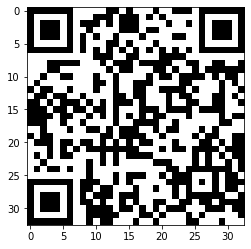

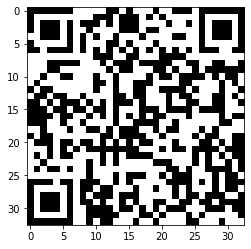

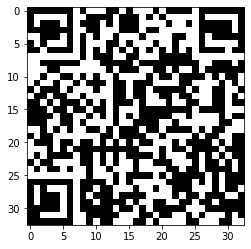

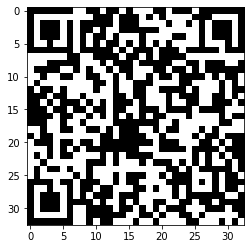

epoch 123 loss: 3.492


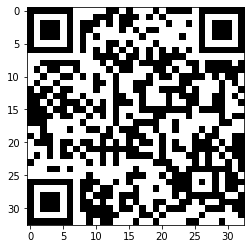

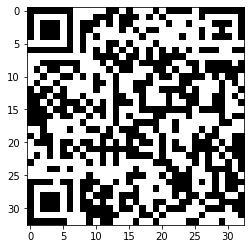

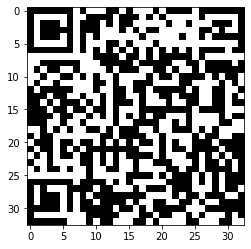

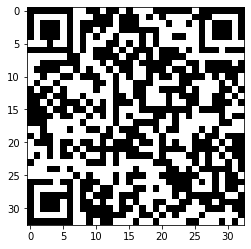

epoch 124 loss: 3.460


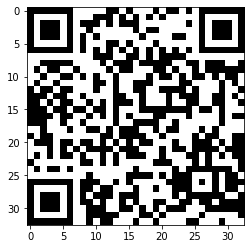

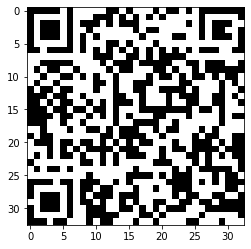

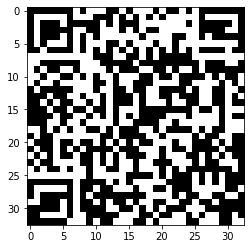

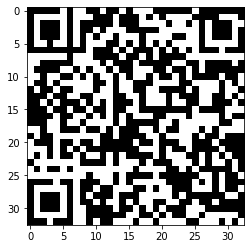

epoch 125 loss: 3.484


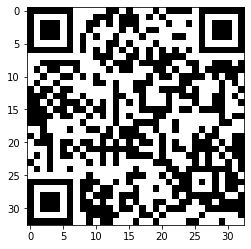

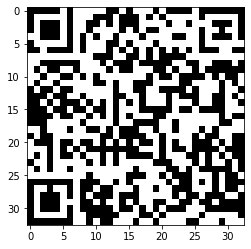

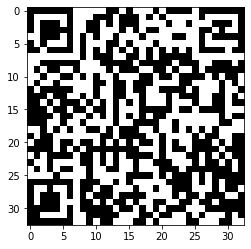

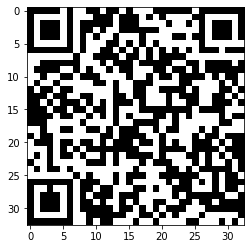

epoch 126 loss: 3.454


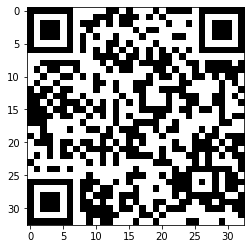

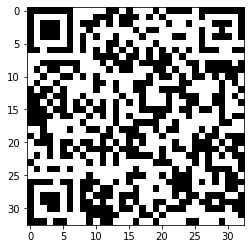

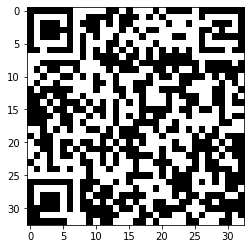

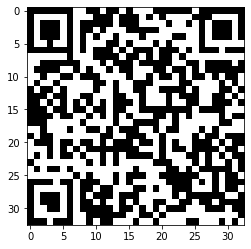

epoch 127 loss: 3.453


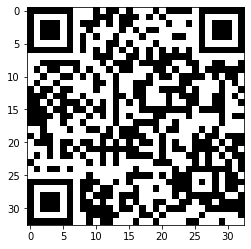

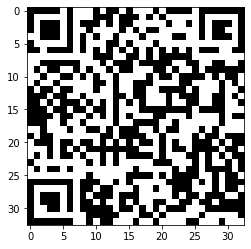

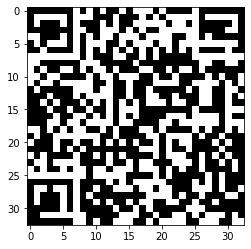

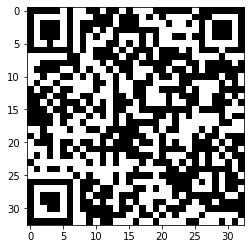

epoch 128 loss: 3.492


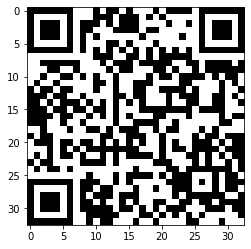

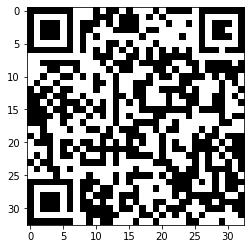

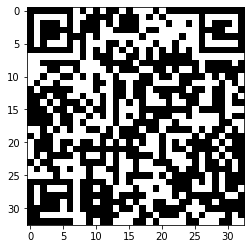

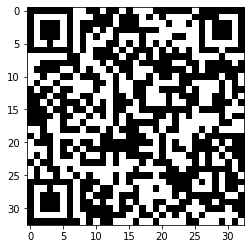

epoch 129 loss: 3.447


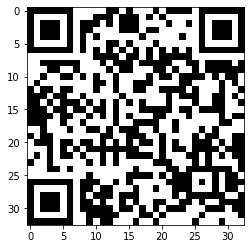

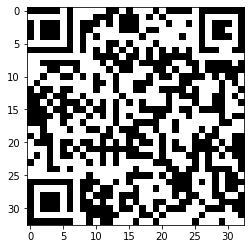

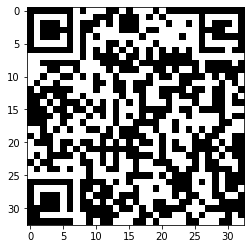

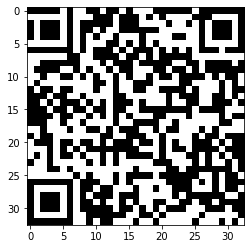

epoch 130 loss: 3.453


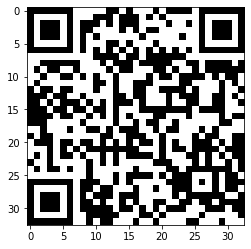

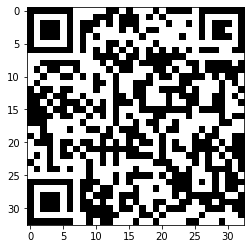

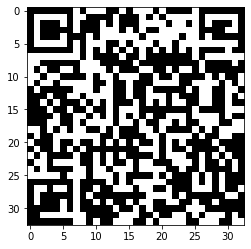

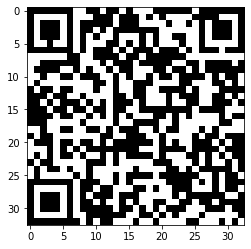

epoch 131 loss: 3.476


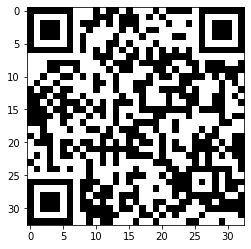

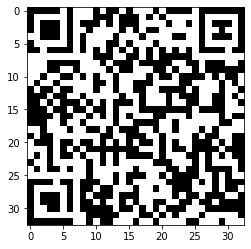

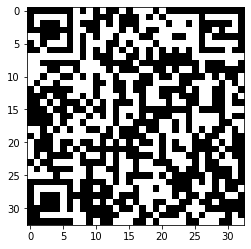

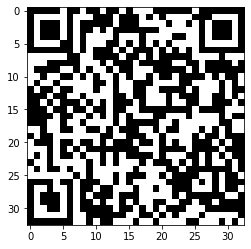

epoch 132 loss: 3.457


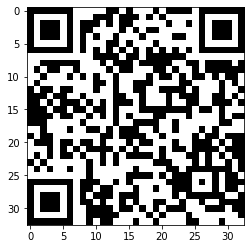

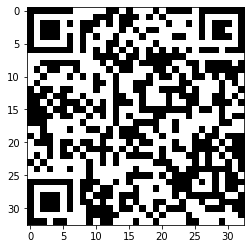

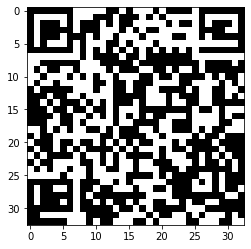

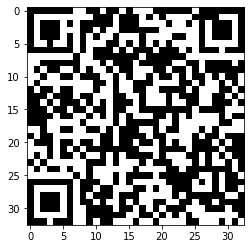

epoch 133 loss: 3.450


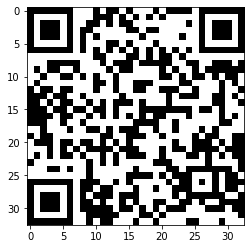

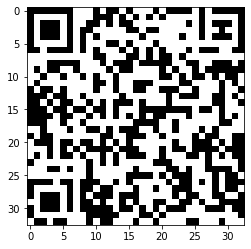

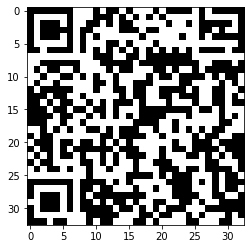

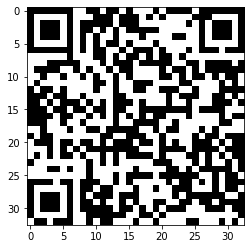

epoch 134 loss: 3.479


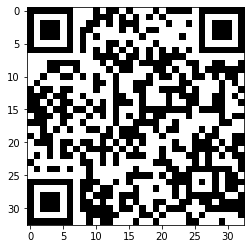

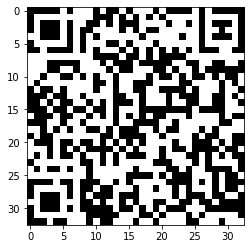

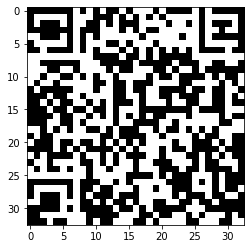

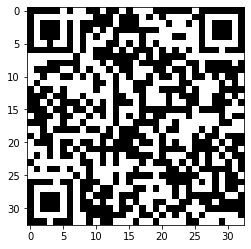

epoch 135 loss: 3.482


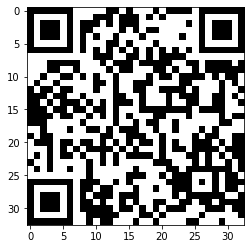

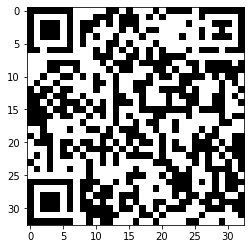

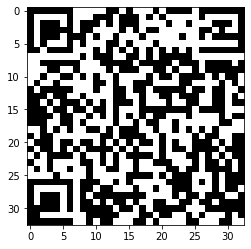

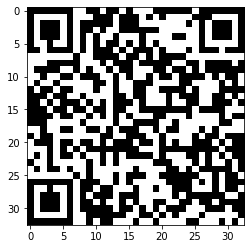

epoch 136 loss: 3.503


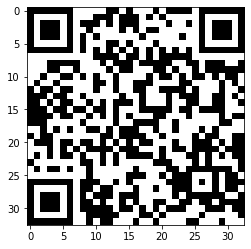

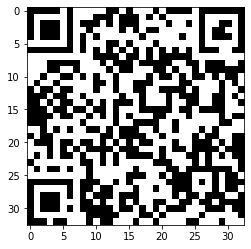

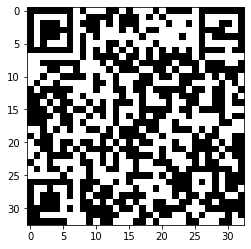

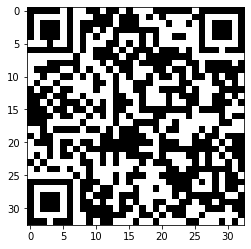

epoch 137 loss: 3.502


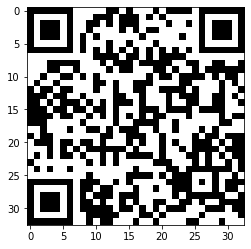

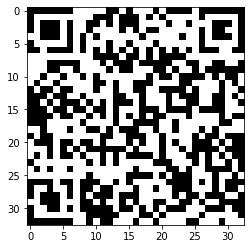

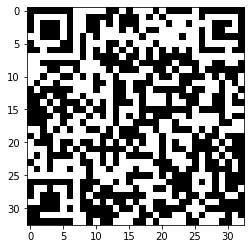

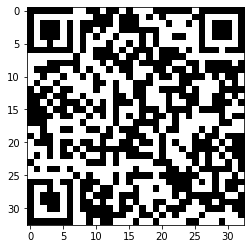

epoch 138 loss: 3.453


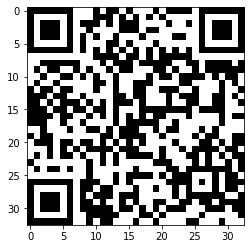

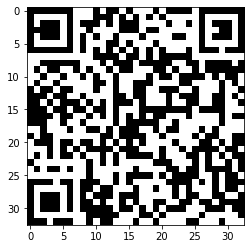

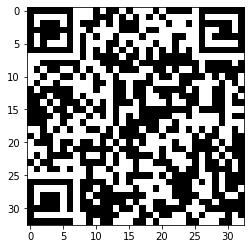

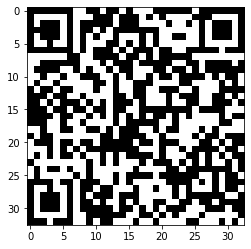

epoch 139 loss: 3.470


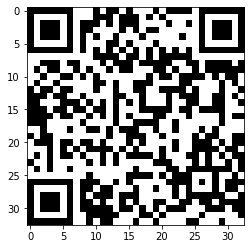

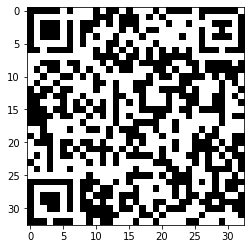

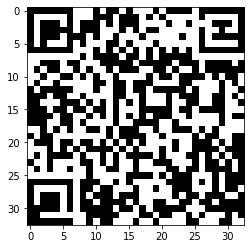

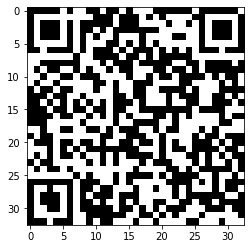

epoch 140 loss: 3.431


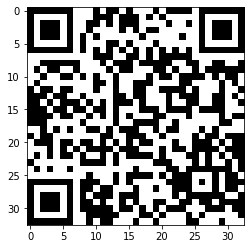

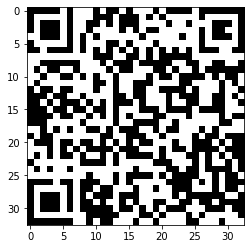

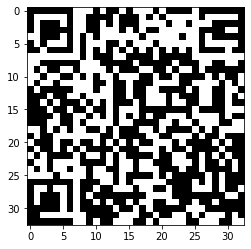

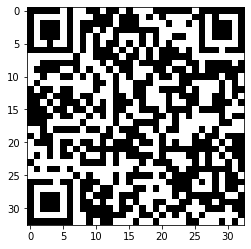

epoch 141 loss: 3.446


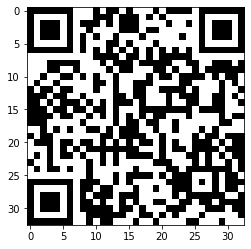

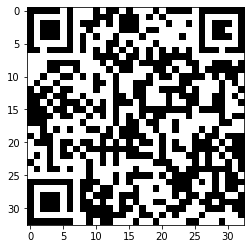

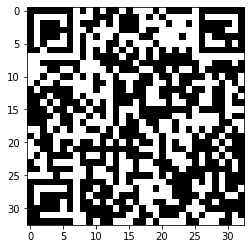

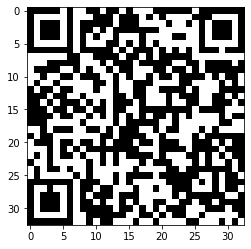

epoch 142 loss: 3.453


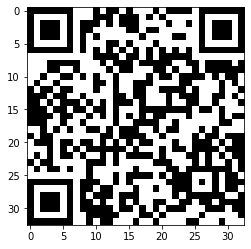

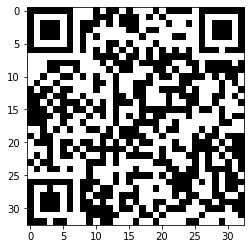

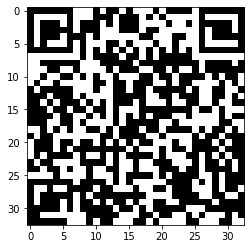

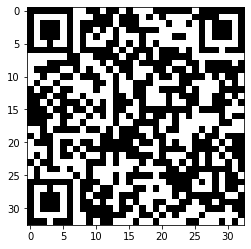

epoch 143 loss: 3.443


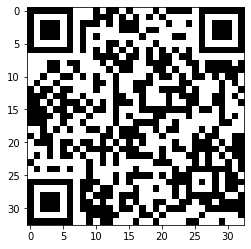

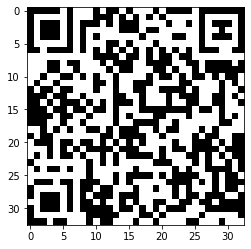

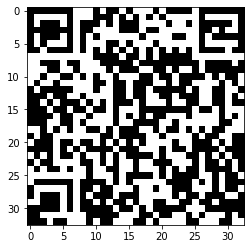

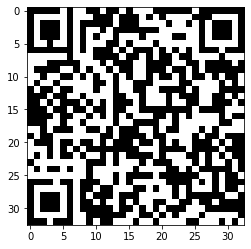

epoch 144 loss: 3.458


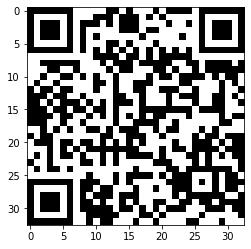

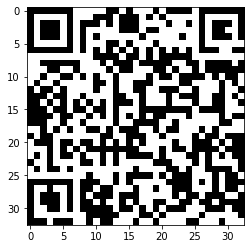

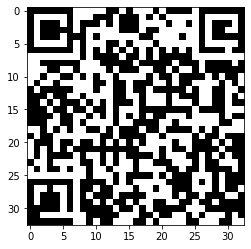

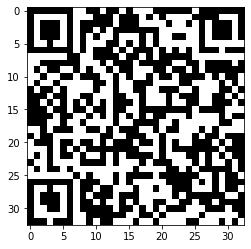

epoch 145 loss: 3.430


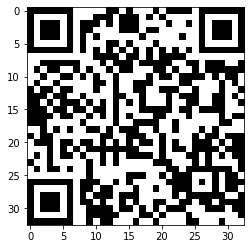

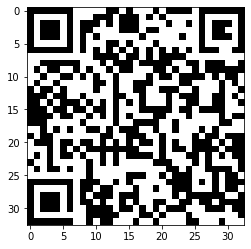

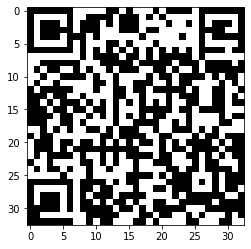

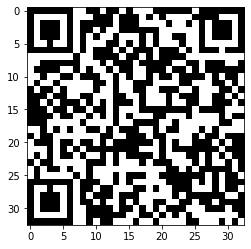

epoch 146 loss: 3.431


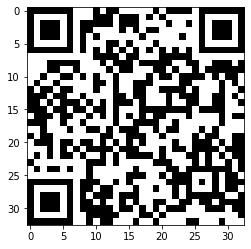

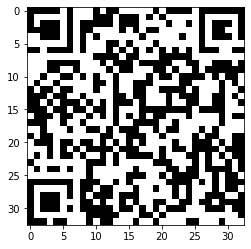

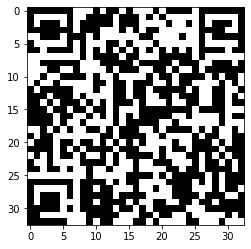

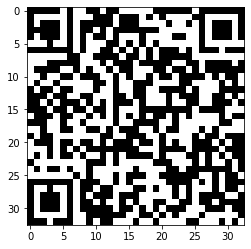

epoch 147 loss: 3.425


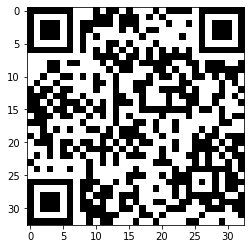

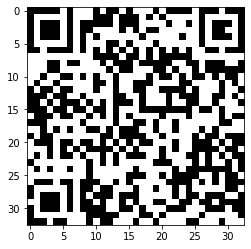

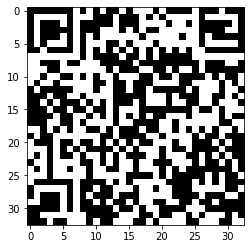

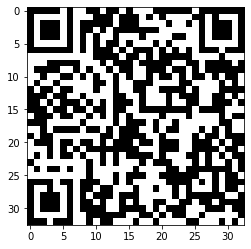

epoch 148 loss: 3.464


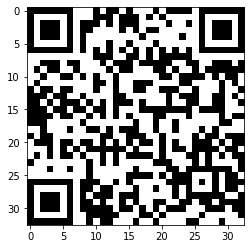

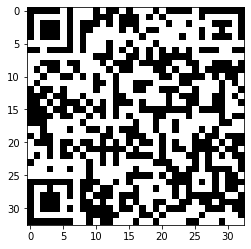

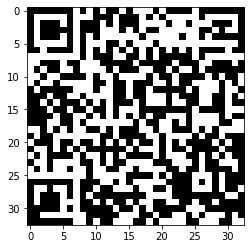

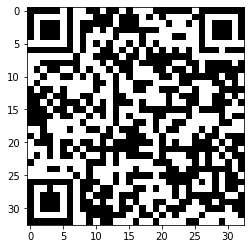

epoch 149 loss: 3.446


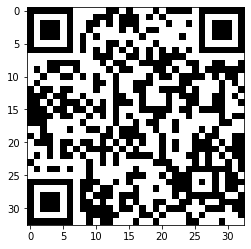

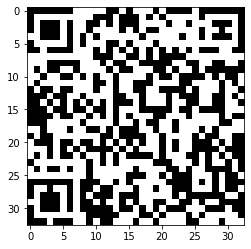

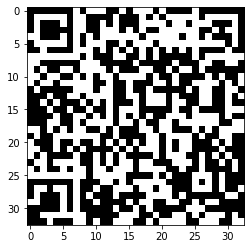

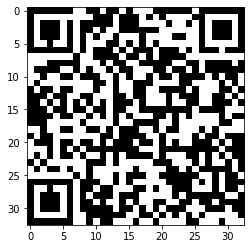

epoch 150 loss: 3.424


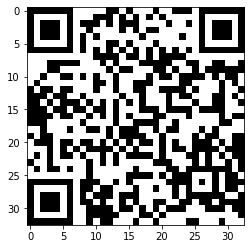

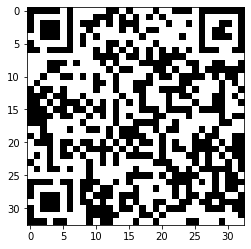

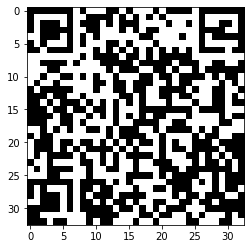

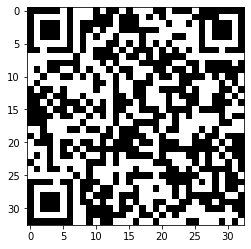

epoch 151 loss: 3.450


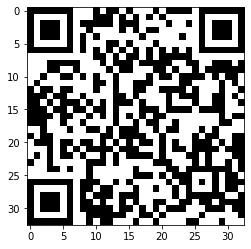

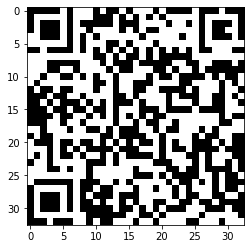

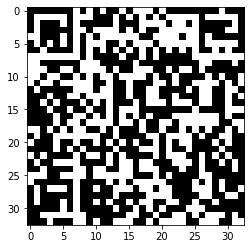

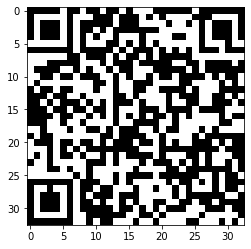

epoch 152 loss: 3.418


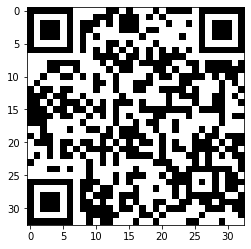

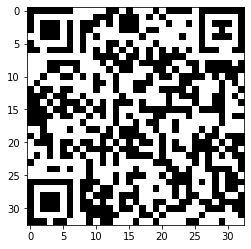

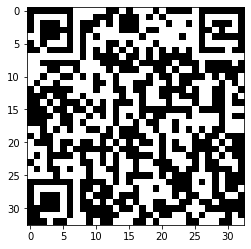

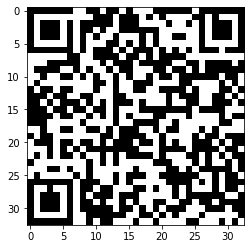

epoch 153 loss: 3.403


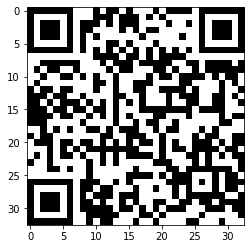

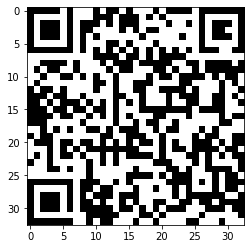

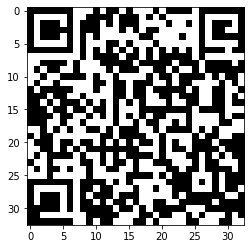

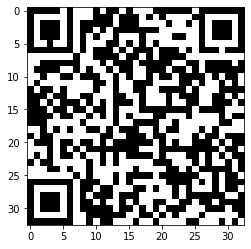

epoch 154 loss: 3.443


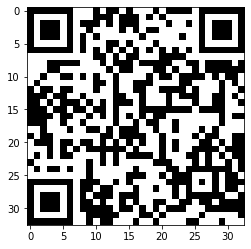

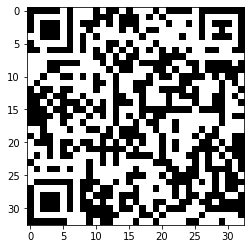

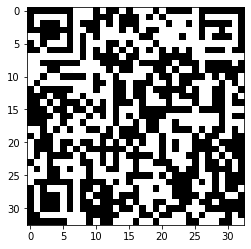

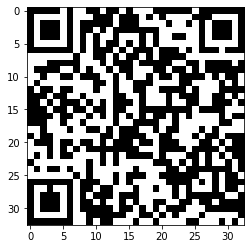

epoch 155 loss: 3.462


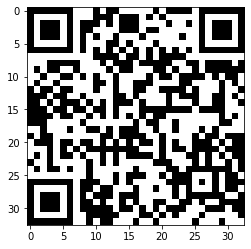

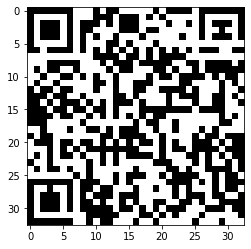

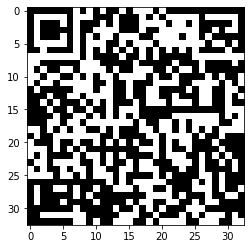

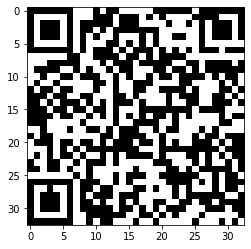

epoch 156 loss: 3.454


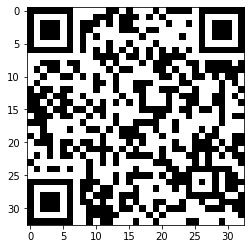

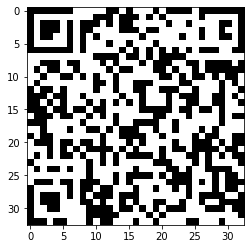

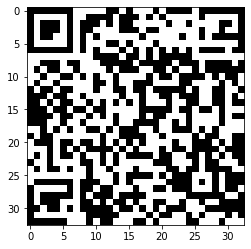

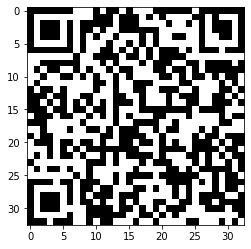

epoch 157 loss: 3.431


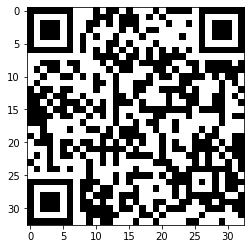

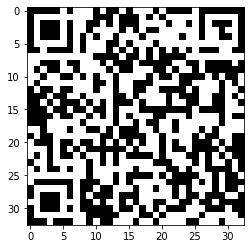

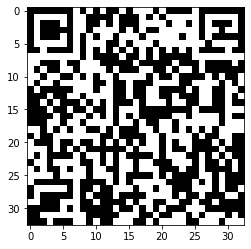

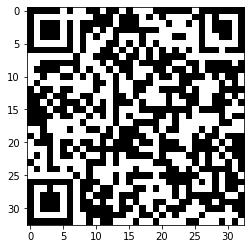

epoch 158 loss: 3.424


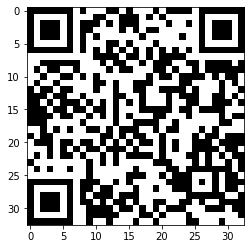

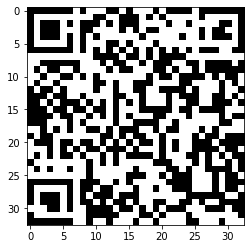

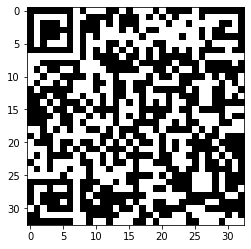

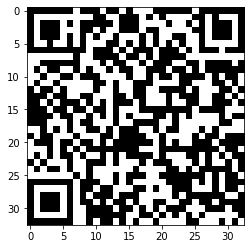

epoch 159 loss: 3.441


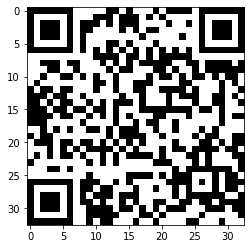

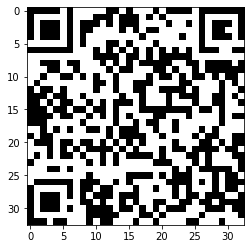

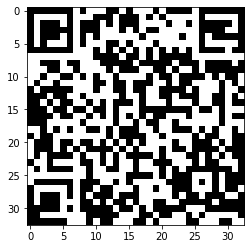

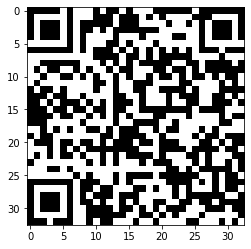

epoch 160 loss: 3.428


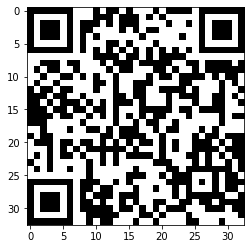

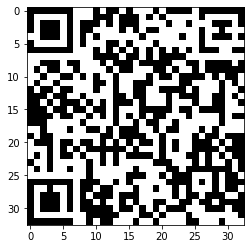

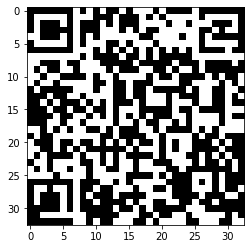

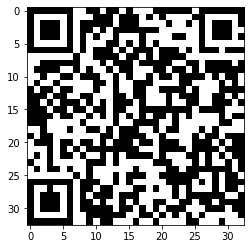

epoch 161 loss: 3.444


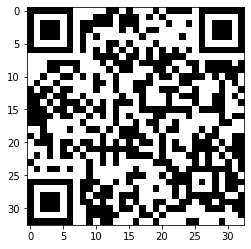

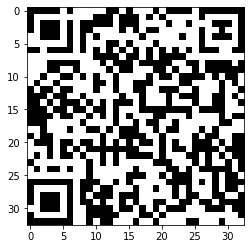

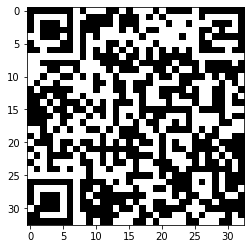

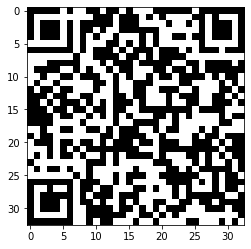

epoch 162 loss: 3.456


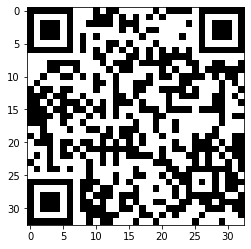

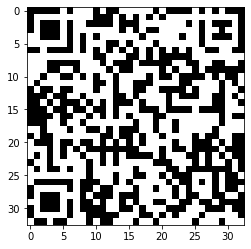

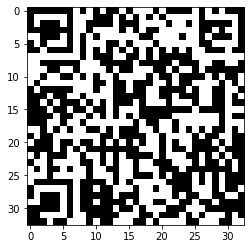

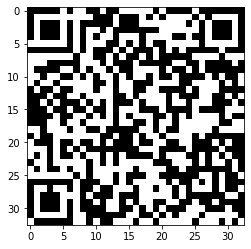

epoch 163 loss: 3.429


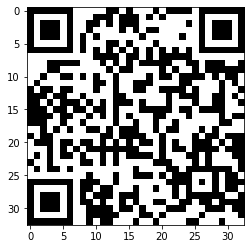

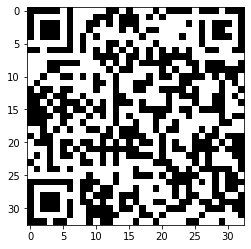

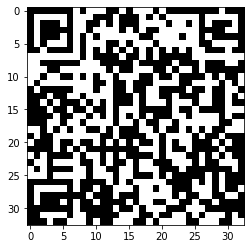

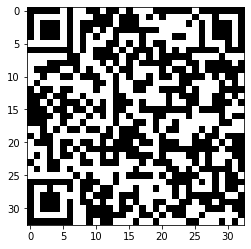

epoch 164 loss: 3.423


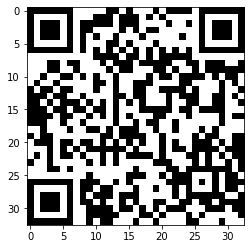

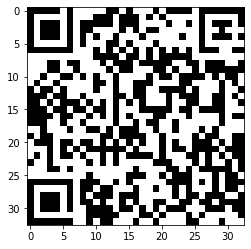

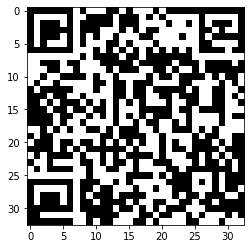

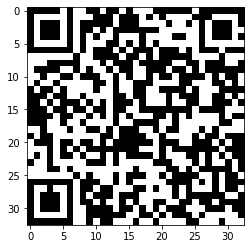

epoch 165 loss: 3.459


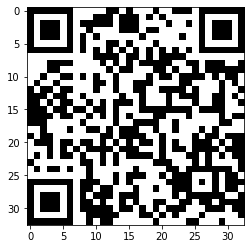

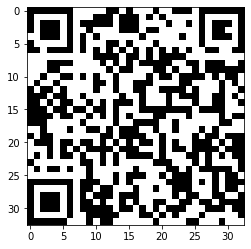

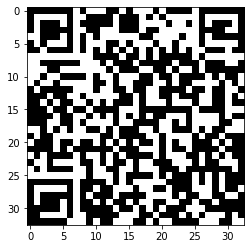

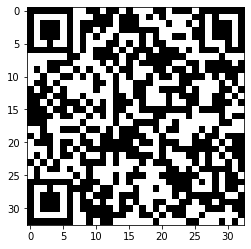

epoch 166 loss: 3.423


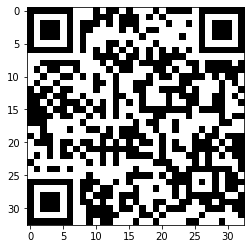

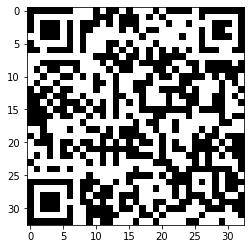

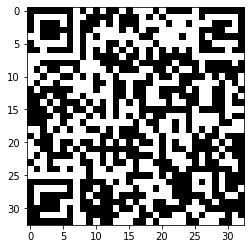

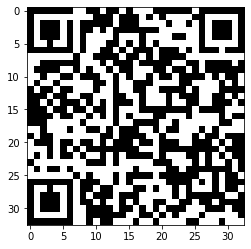

epoch 167 loss: 3.421


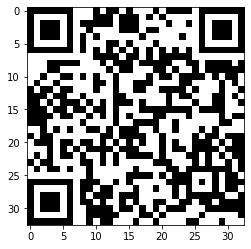

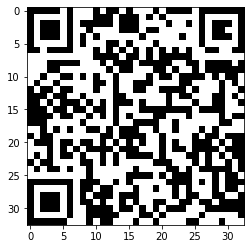

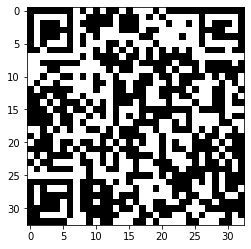

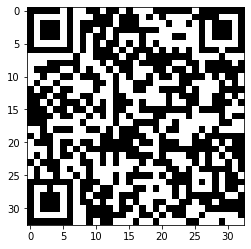

epoch 168 loss: 3.415


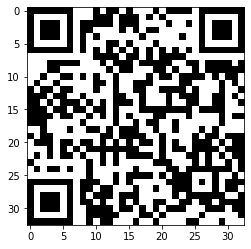

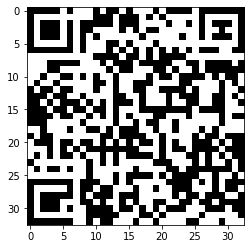

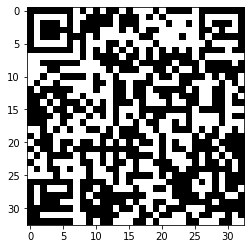

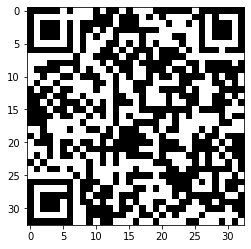

epoch 169 loss: 3.402


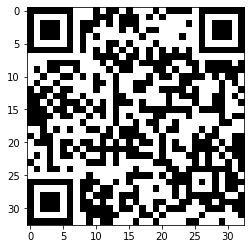

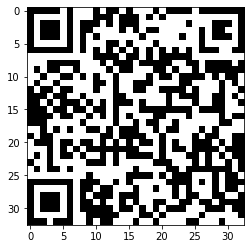

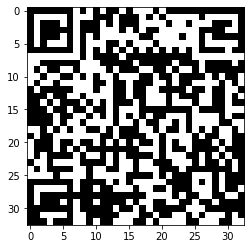

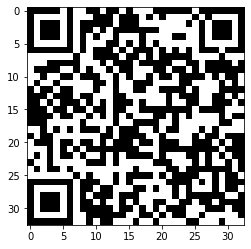

epoch 170 loss: 3.410


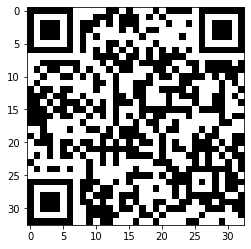

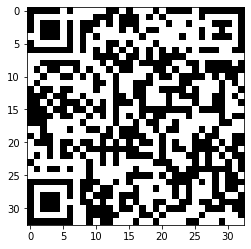

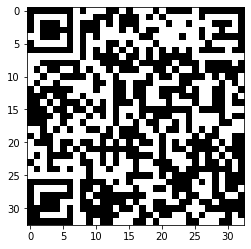

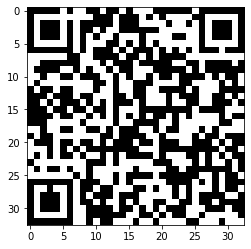

epoch 171 loss: 3.410


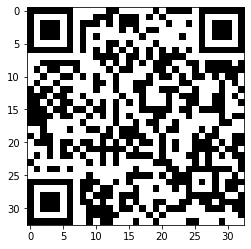

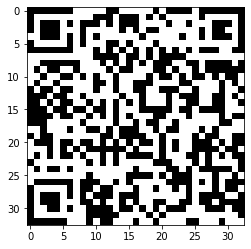

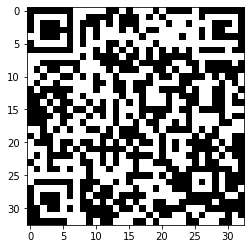

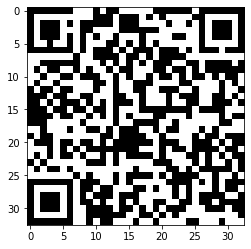

epoch 172 loss: 3.466


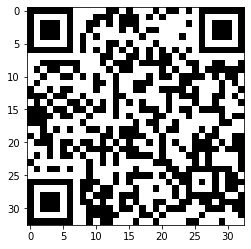

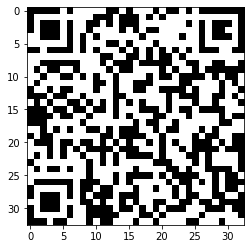

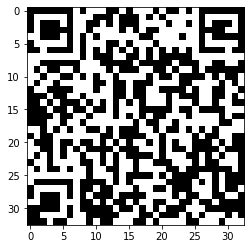

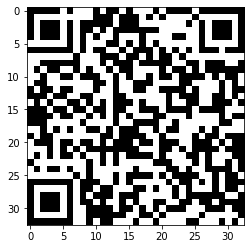

epoch 173 loss: 3.441


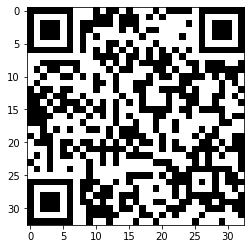

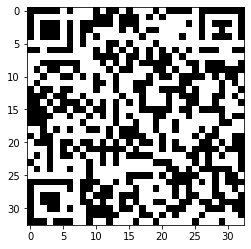

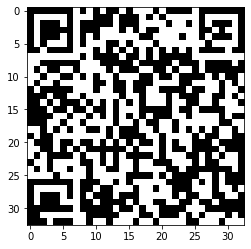

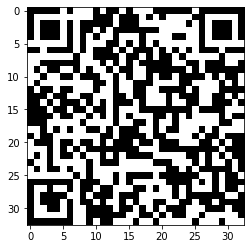

epoch 174 loss: 3.429


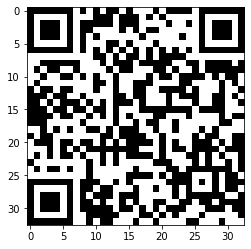

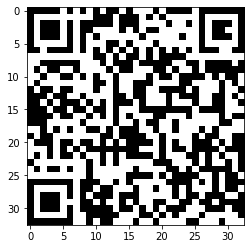

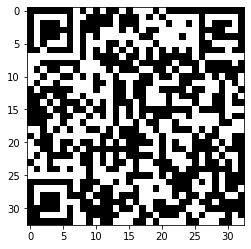

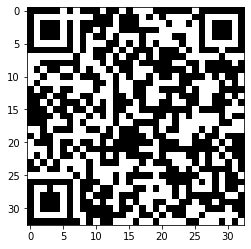

epoch 175 loss: 3.446


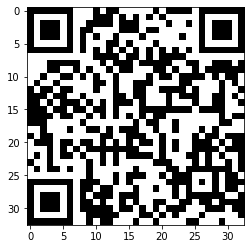

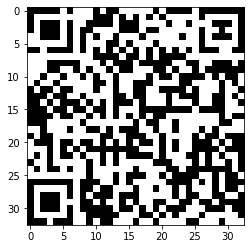

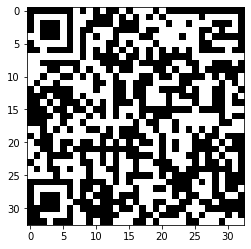

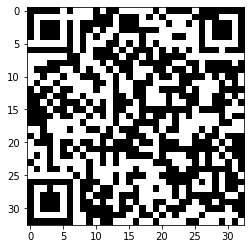

epoch 176 loss: 3.455


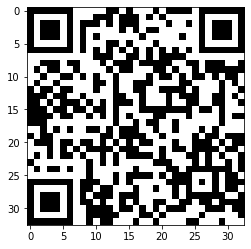

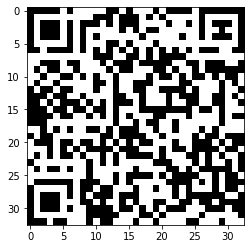

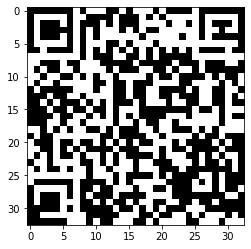

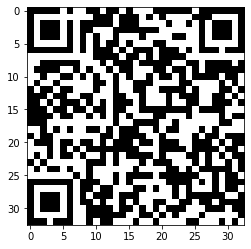

epoch 177 loss: 3.425


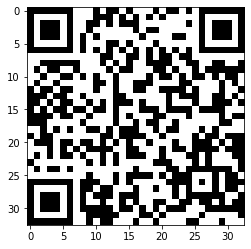

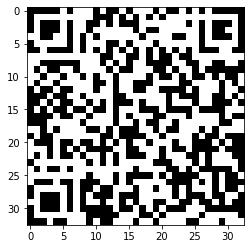

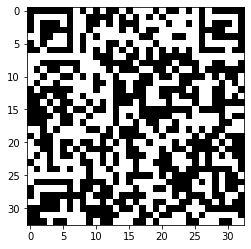

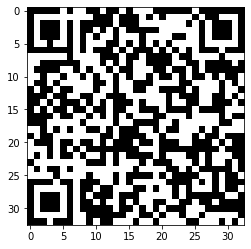

epoch 178 loss: 3.439


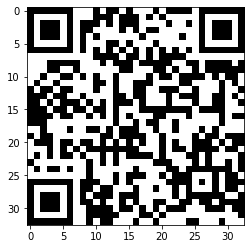

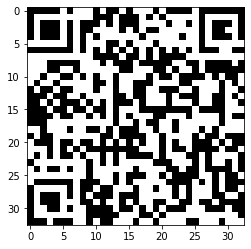

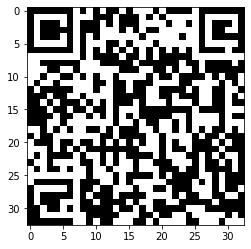

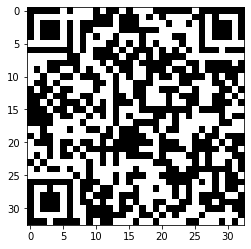

epoch 179 loss: 3.400


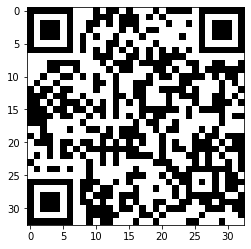

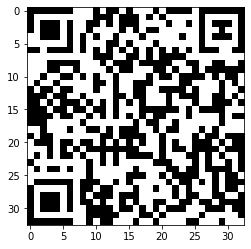

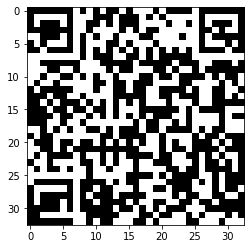

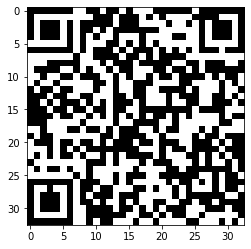

epoch 180 loss: 3.389


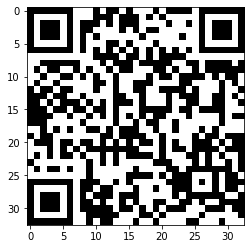

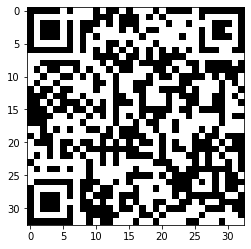

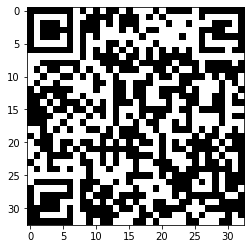

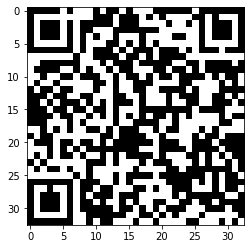

epoch 181 loss: 3.387


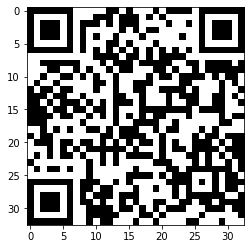

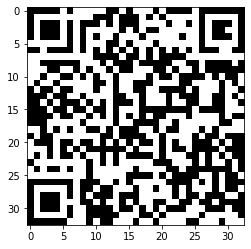

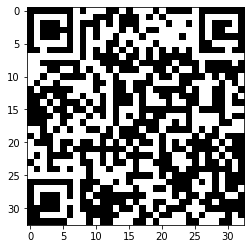

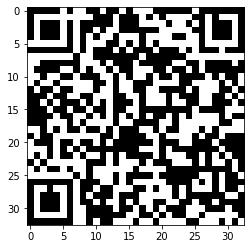

epoch 182 loss: 3.425


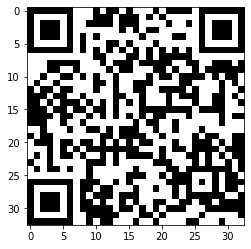

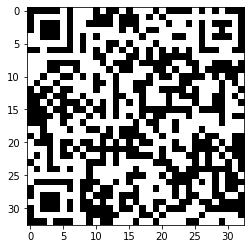

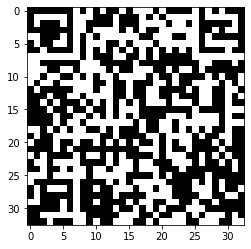

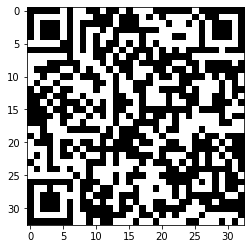

epoch 183 loss: 3.432


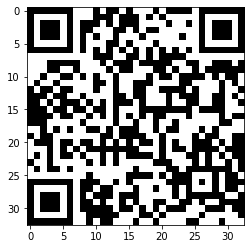

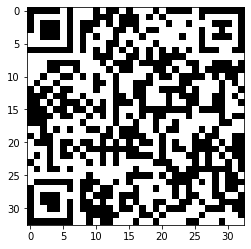

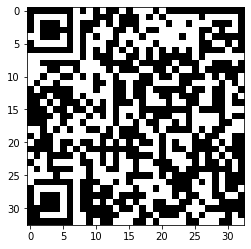

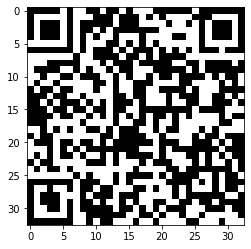

epoch 184 loss: 3.391


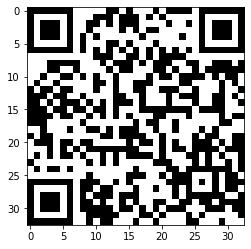

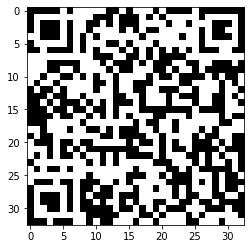

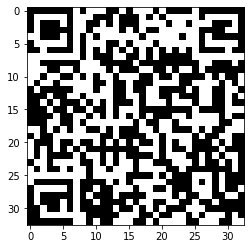

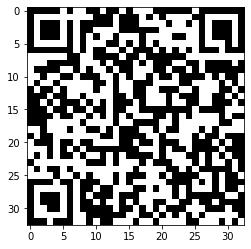

epoch 185 loss: 3.419


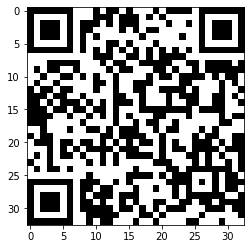

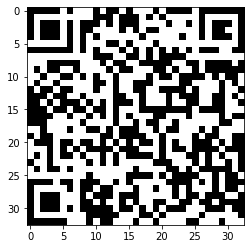

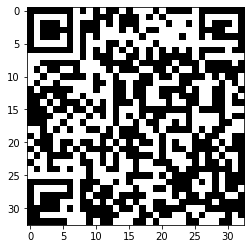

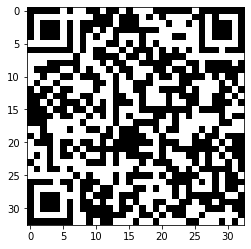

epoch 186 loss: 3.453


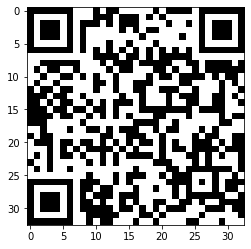

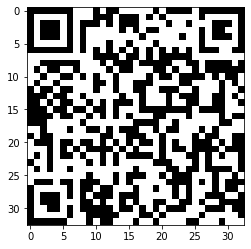

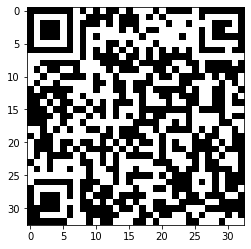

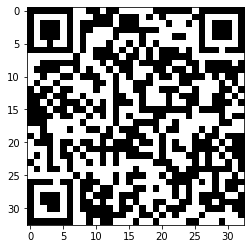

epoch 187 loss: 3.410


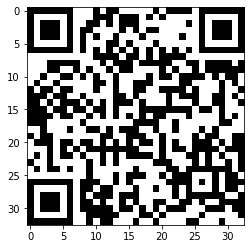

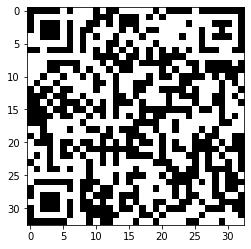

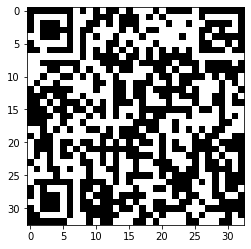

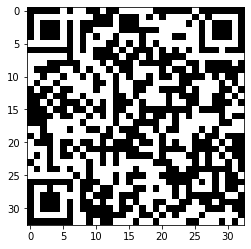

epoch 188 loss: 3.415


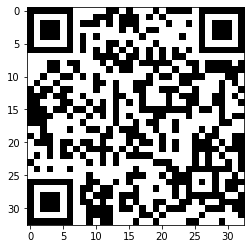

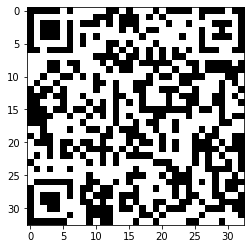

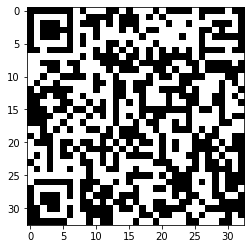

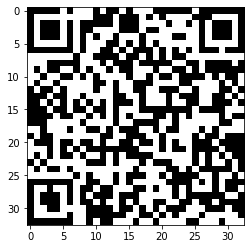

epoch 189 loss: 3.411


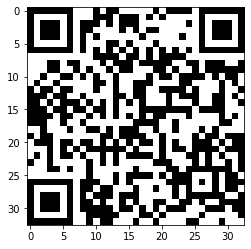

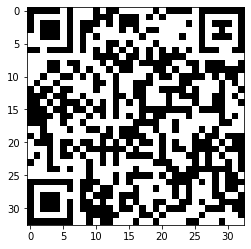

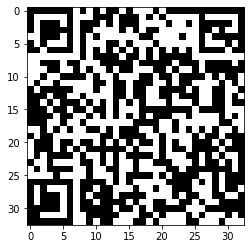

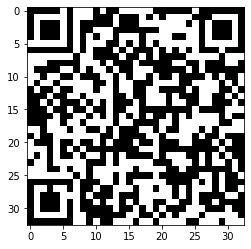

epoch 190 loss: 3.424


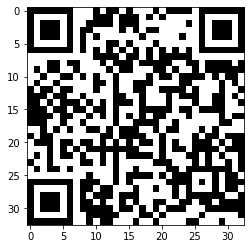

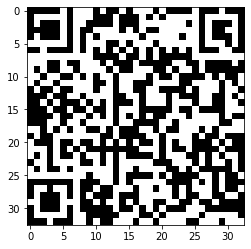

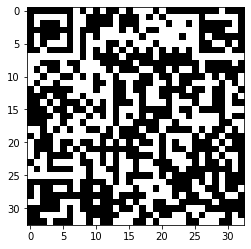

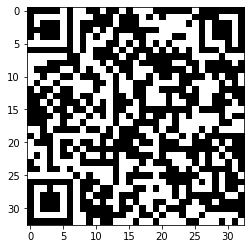

epoch 191 loss: 3.380


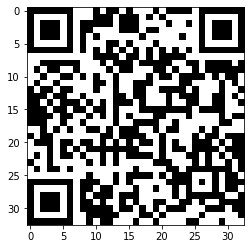

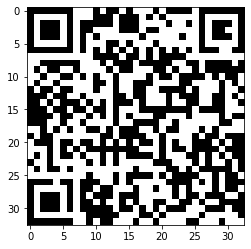

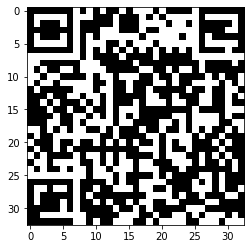

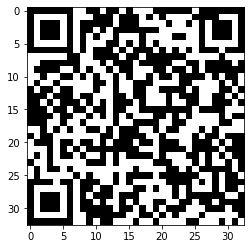

epoch 192 loss: 3.388


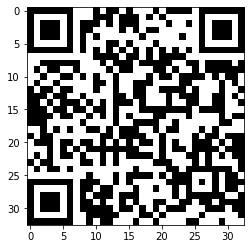

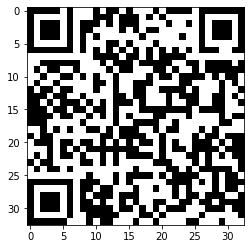

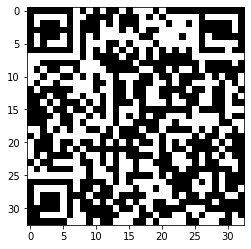

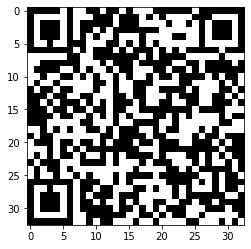

epoch 193 loss: 3.375


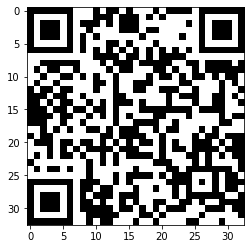

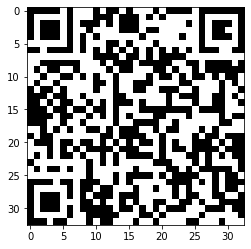

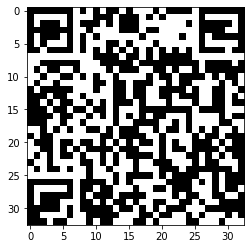

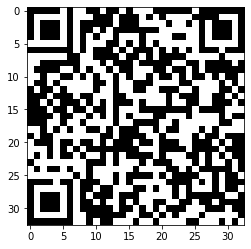

epoch 194 loss: 3.381


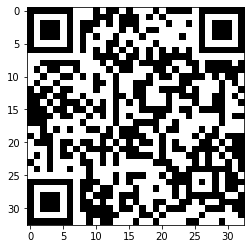

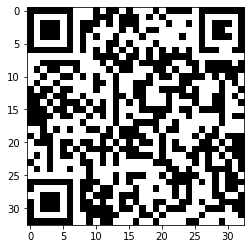

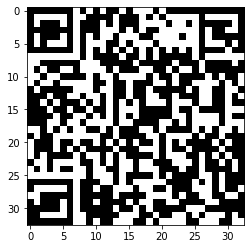

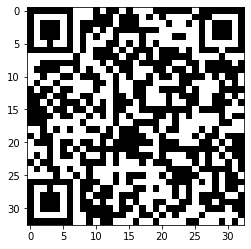

epoch 195 loss: 3.407


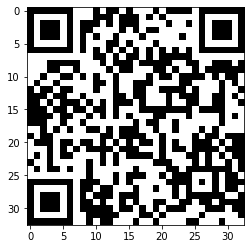

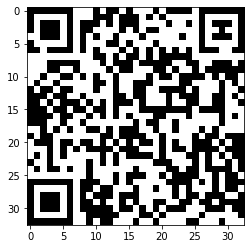

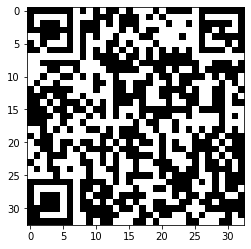

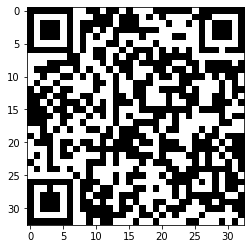

epoch 196 loss: 3.441


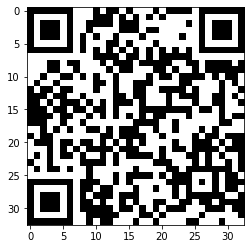

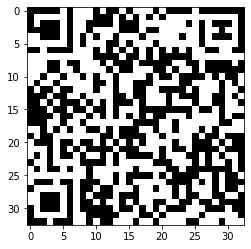

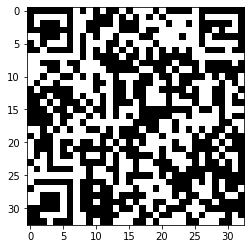

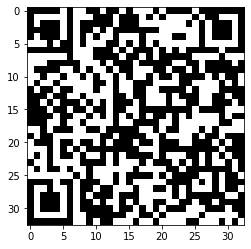

epoch 197 loss: 3.421


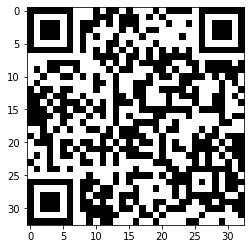

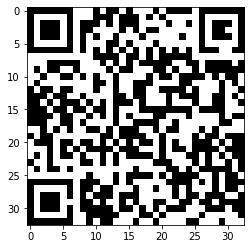

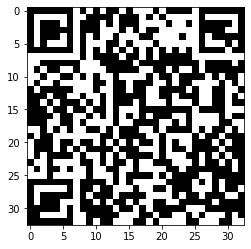

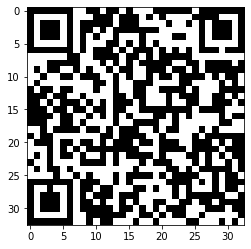

epoch 198 loss: 3.408


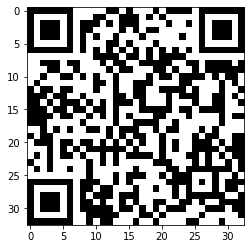

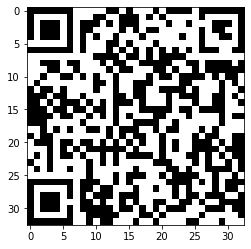

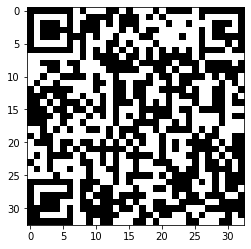

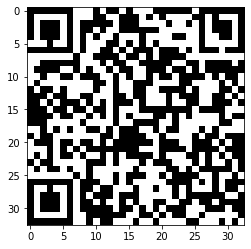

epoch 199 loss: 3.401


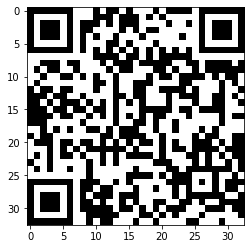

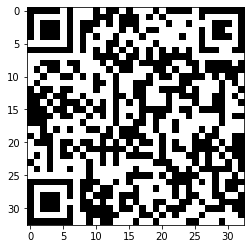

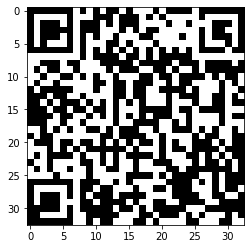

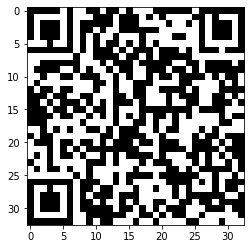

epoch 200 loss: 3.401


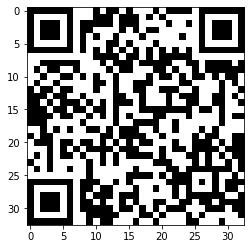

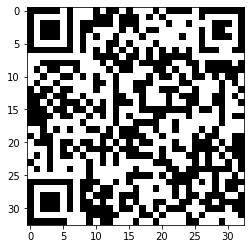

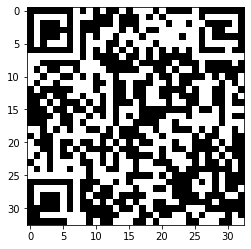

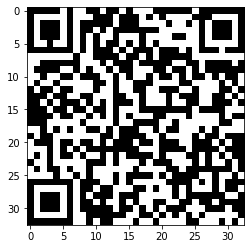

KeyboardInterrupt: 

In [16]:
model.train()

for epoch in range(48):  # loop over the dataset multiple times
	running_loss = 0.0
	model.train()
	for i, data in enumerate(train_loader, 0):
		X, y, _ = data
		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		outputs = model(X)
		loss = loss_func(outputs, y)
		loss.backward()
		optimizer.step()
		# print statistics
		running_loss += loss.item()

	print("epoch %d loss: %.3f" % (epoch+1, running_loss / batch_size))

	model.eval()
	resp = build_response(test_images, model)
	qr = np.uint8(np.where((mask[:, :, 1] != 255) | (mask[:, :, 0] != 0), np.where(mask[:, :, 0] == 255, 0, 1), resp[:, :, 0] & resp[:, :, 1]))*255
	
	#print(qr)
	plt.figure()
	plt.imshow(qr, cmap="Greys")
	plt.show()
	plt.imshow(resp[:, :, 0] & resp[:, :, 1], cmap="Greys")
	plt.show()
	plt.imshow(resp[:, :, 0], cmap="Greys")
	plt.show()
	plt.imshow(resp[:, :, 1], cmap="Greys")
	plt.show()

	flag = read_qr_code(qr)
	if len(flag) > 0:
		print(flag)
		break

In [16]:
#torch.save(model.state_dict(), "model.pt")
model.eval()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=4624, out_features=256, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.15, inplace=False)
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=2, bias=True)
  (13): Softmax(dim=1)
)

In [ ]:
final = build_response(test_images, model)

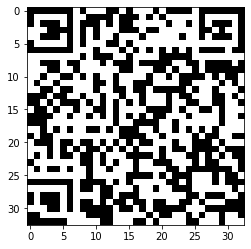

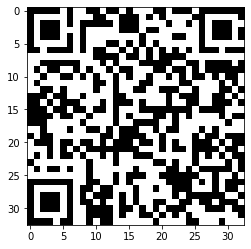

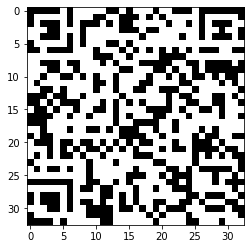

In [49]:
plt.figure()
plt.imshow(final[:, :, 0], cmap="Greys")

print(read_qr_code(final[:, :, 0]))

plt.figure()
plt.imshow(final[:, :, 1], cmap="Greys")

print(read_qr_code(final[:, :, 1]))

res = final[:, :, 0] & final[:, :, 1]

plt.figure()
plt.imshow(res, cmap="Greys")

print(read_qr_code(res))

In [52]:
res

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

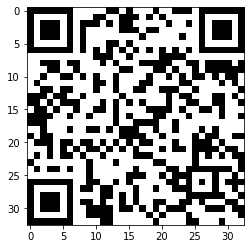

In [53]:
img = np.uint8(np.where((mask[:, :, 1] != 255) | (mask[:, :, 0] != 0), np.where(mask[:, :, 0] == 255, 0, 1), res))

plt.figure()
plt.imshow(img, cmap="Greys")

print(read_qr_code(img))

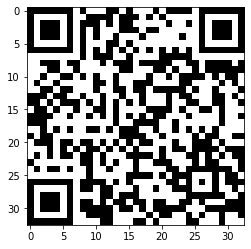

In [54]:
img = np.uint8(np.where((mask[:, :, 1] != 255) | (mask[:, :, 0] != 0), np.where(mask[:, :, 0] == 255, 0, 1), final[:, :, 0]))

plt.figure()
plt.imshow(img, cmap="Greys")

print(read_qr_code(img))

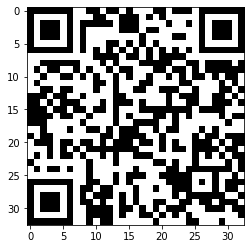

In [55]:
img = np.uint8(np.where((mask[:, :, 1] != 255) | (mask[:, :, 0] != 0), np.where(mask[:, :, 0] == 255, 0, 1), final[:, :, 1]))

plt.figure()
plt.imshow(img, cmap="Greys")

print(read_qr_code(img))